<a href="https://colab.research.google.com/github/pes1ug23am354/TEAM_09_ML_HACKATHON/blob/main/Complete_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hangman ML Hackathon - Complete Solution

## ⚠️ **EXECUTION ORDER IS CRITICAL!** ⚠️

**You MUST run cells in order from top to bottom!**

**Common Error: `NameError: name 'FirstOrderHMM' is not defined`**
- **Cause**: You ran a cell that uses `FirstOrderHMM` before running the cell that defines it
- **Fix**: Run Cell 16 (defines FirstOrderHMM class) before Cell 28 (uses FirstOrderHMM)

**Quick Execution Guide:**
1. **Cell 1**: Import libraries
2. **Cells 2-13**: Load and preprocess data  
3. **Cell 14**: Define `HangmanEnv` class
4. **Cell 15**: Test environment
5. **Cell 16**: **Define `FirstOrderHMM` class** ← MUST RUN BEFORE CELL 28!
6. **Cells 17-23**: HMM training and validation
7. **Cells 24-27**: Define RL agents (`QLearningAgent` and `DQNAgent`)
8. **Cell 28+**: Training and evaluation

**🚀 Key Improvements:**
- HMM-Greedy Evaluation Mode
- Dynamic probability calculation per word
- DQN support for better learning
- Heavy HMM weighting (20x)


# Hangman ML Hackathon - Complete Solution

This notebook implements a complete Hangman solver using:
1. **Hidden Markov Model (HMM)** - Language model for letter probability estimation
2. **Reinforcement Learning (RL)** - Q-Learning agent for optimal guessing strategy
3. **Hybrid System** - Combines HMM + RL for intelligent gameplay

## Implementation Features

✅ **Proper Training Workflow:**
- Stage 1: HMM Training (with validation)
- Stage 2: RL Baseline Setup
- Stage 3: Hybrid HMM + RL Training
- Stage 4: Final Evaluation

✅ **Overfitting/Underfitting Prevention:**
- HMM: Perplexity validation, additive smoothing
- RL: Validation monitoring, noise injection, word shuffling
- Comprehensive diagnostics

✅ **Online Learning:**
- HMM probabilities recalculated after each guess
- Q-values updated immediately after each action
- Step-by-step learning (not batch learning)

✅ **Data Quality:**
- Comprehensive preprocessing (case, typos, duplicates)
- Word buckets by length
- Train/validation/test split

**Run cells sequentially from top to bottom!**


In [183]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import random
import pickle
import os
import sys

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Display settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load Data


In [184]:
# Load data files
import os

# Get the directory containing this notebook
notebook_dir = os.path.dirname(os.path.abspath('__file__' if '__file__' in globals() else '.'))
# Go up one level to project root
project_root = os.path.dirname(notebook_dir) if os.path.basename(notebook_dir) == 'notebooks' else notebook_dir

# Try multiple possible paths
possible_corpus_paths = [
    os.path.join(os.getcwd(), 'corpus.txt'), # Look in current directory
    os.path.join(project_root, 'Data', 'corpus.txt'),
    os.path.join('..', 'Data', 'corpus.txt'),
    'Data/corpus.txt',
    '../Data/corpus.txt',
    os.path.join(os.getcwd(), 'Data', 'corpus.txt')
]

possible_test_paths = [
    os.path.join(os.getcwd(), 'test.txt'), # Look in current directory
    os.path.join(project_root, 'Data', 'test.txt'),
    os.path.join('..', 'Data', 'test.txt'),
    'Data/test.txt',
    '../Data/test.txt',
    os.path.join(os.getcwd(), 'Data', 'test.txt')
]

corpus_path = None
test_path = None

for path in possible_corpus_paths:
    if os.path.exists(path):
        corpus_path = path
        break

for path in possible_test_paths:
    if os.path.exists(path):
        test_path = path
        break

if corpus_path is None or test_path is None:
    print("ERROR: Could not find data files!")
    print(f"Tried corpus paths: {possible_corpus_paths}")
    print(f"Tried test paths: {possible_test_paths}")
    print(f"Current directory: {os.getcwd()}")
    print(f"Files in current dir: {os.listdir('.')}")
    raise FileNotFoundError("Data files not found! Please check the paths.")

print(f"Found corpus: {corpus_path}")
print(f"Found test: {test_path}")

# Load data
print("Loading raw data files...")
with open(corpus_path, 'r', encoding='utf-8') as f:
    corpus_raw = [line.strip() for line in f if line.strip()]

print(f"Raw corpus: {len(corpus_raw)} lines")

with open(test_path, 'r', encoding='utf-8') as f:
    test_words_raw = [line.strip() for line in f if line.strip()]

print(f"Raw test: {len(test_words_raw)} lines")
print(f"\nSample raw corpus words (first 10): {corpus_raw[:10]}")
print(f"Sample raw test words (first 10): {test_words_raw[:10]}")

if len(corpus_raw) == 0:
    raise ValueError("corpus_raw is empty! Check the data file.")
if len(test_words_raw) == 0:
    raise ValueError("test_words_raw is empty! Check the data file.")

Found corpus: /content/corpus.txt
Found test: /content/test.txt
Loading raw data files...
Raw corpus: 50000 lines
Raw test: 2000 lines

Sample raw corpus words (first 10): ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography']
Sample raw test words (first 10): ['marmar', 'janet', 'dentistical', 'troveless', 'unnotify', 'gastrostenosis', 'preaffiliation', 'obpyriform', 'veratrinize', 'protection']


## 1.0 Data Cleaning and Preprocessing

Comprehensive preprocessing pipeline:
1. Case normalization (upper/lower case handling)
2. Remove non-alphabetic characters
3. Handle mispellings/typos (optional spell checking)
4. Remove duplicates
5. Filter by length and quality


In [185]:
import re
from difflib import SequenceMatcher

def normalize_case(word, case_mode='lower'):
    """
    Normalize word case.

    Args:
        word: Input word
        case_mode: 'lower', 'upper', or 'preserve'

    Returns:
        Normalized word
    """
    if case_mode == 'lower':
        return word.lower()
    elif case_mode == 'upper':
        return word.upper()
    else:
        return word

def remove_non_alphabetic(word):
    """
    Remove all non-alphabetic characters.

    Args:
        word: Input word

    Returns:
        Word with only alphabetic characters
    """
    return ''.join([c for c in word if c.isalpha()])

def remove_special_characters(word):
    """
    Remove special characters but keep alphabetic and basic characters.
    """
    # Keep only letters and basic characters
    return re.sub(r'[^a-zA-Z]', '', word)

def fix_common_typos(word):
    """
    Fix common typos and character confusions.
    """
    # Common typo fixes
    typo_fixes = {
        # Common character confusions
        '0': 'o', 'O': 'o',
        '1': 'i', 'I': 'i',
        '3': 'e',
        '5': 's',
        '@': 'a',
        # Remove numbers and special chars (handled separately)
    }

    fixed = word
    for typo, correct in typo_fixes.items():
        fixed = fixed.replace(typo, correct)

    return fixed

def is_valid_word(word, min_length=2, max_length=25):
    """
    Check if word is valid after cleaning.

    Args:
        word: Word to check
        min_length: Minimum valid length
        max_length: Maximum valid length

    Returns:
        bool: True if word is valid
    """
    if not word:
        return False

    if len(word) < min_length or len(word) > max_length:
        return False

    # Check if word contains only alphabetic characters
    if not word.isalpha():
        return False

    return True

def remove_duplicates_keep_order(words):
    """
    Remove duplicates while preserving order.
    """
    seen = set()
    unique_words = []
    for word in words:
        if word not in seen:
            seen.add(word)
            unique_words.append(word)
    return unique_words

def clean_and_preprocess_word(word,
                             normalize_case_mode='lower',
                             remove_non_alpha=True,
                             fix_typos=True,
                             min_length=2,
                             max_length=25):
    """
    Complete preprocessing pipeline for a single word.

    Args:
        word: Raw word
        normalize_case_mode: 'lower', 'upper', or 'preserve'
        remove_non_alpha: Remove non-alphabetic characters
        fix_typos: Attempt to fix common typos
        min_length: Minimum word length
        max_length: Maximum word length

    Returns:
        Cleaned word or None if invalid
    """
    # Step 1: Normalize case
    cleaned = normalize_case(word, normalize_case_mode)

    # Step 2: Fix common typos (do before removing non-alpha to catch digit confusions)
    if fix_typos:
        cleaned = fix_common_typos(cleaned)

    # Step 3: Remove non-alphabetic characters
    if remove_non_alpha:
        cleaned = remove_non_alphabetic(cleaned)

    # Step 4: Validate
    if not is_valid_word(cleaned, min_length, max_length):
        return None

    return cleaned


def preprocess_word_list(words,
                         normalize_case_mode='lower',
                         remove_non_alpha=True,
                         fix_typos=True,
                         min_length=3,
                         max_length=15,
                         remove_duplicates=True,
                         verbose=True):
    """
    Clean and preprocess a list of words.

    Args:
        words: List of raw words
        normalize_case_mode: 'lower', 'upper', or 'preserve'
        remove_non_alpha: Remove non-alphabetic characters
        fix_typos: Attempt to fix common typos
        min_length: Minimum word length
        max_length: Maximum word length
        remove_duplicates: Remove duplicate words
        verbose: Print preprocessing statistics

    Returns:
        list: List of cleaned and preprocessed words
        dict: Statistics about the preprocessing process
    """
    cleaned_words = []
    stats = {
        'original_count': len(words),
        'removed_words': [],
        'after_cleaning': 0,
        'after_length_filter': 0,
        'after_duplicate_removal': 0,
        'duplicates_removed': 0,
        'final_count': 0
    }

    # Apply cleaning and validation to each word
    for word in words:
        original = word

        # Clean word
        cleaned = clean_and_preprocess_word(
            word,
            normalize_case_mode=normalize_case_mode,
            remove_non_alpha=remove_non_alpha,
            fix_typos=fix_typos,
            min_length=min_length,
            max_length=max_length
        )

        if cleaned is not None:
            cleaned_words.append(cleaned)
        else:
            stats['removed_words'].append(original)

    stats['after_length_filter'] = len(cleaned_words)

    # Remove duplicates
    if remove_duplicates:
        before_dup_removal = len(cleaned_words)
        cleaned_words = remove_duplicates_keep_order(cleaned_words)
        stats['after_duplicate_removal'] = len(cleaned_words)
        stats['duplicates_removed'] = before_dup_removal - len(cleaned_words)

    stats['final_count'] = len(cleaned_words)

    if verbose:
        print(f"Preprocessing Statistics:")
        print(f"  Original words: {stats['original_count']}")
        print(f"  After cleaning: {stats['final_count']}")
        print(f"  Removed: {stats['original_count'] - stats['final_count']}")
        if remove_duplicates:
            print(f"  Duplicates removed: {stats.get('duplicates_removed', 0)}")
        if stats.get('original_count', 0) > 0:
            print(f"  Removal rate: {(stats['original_count'] - stats['final_count']) / stats['original_count'] * 100:.2f}%")
        else:
            print(f"  Removal rate: N/A (original count was 0)")

    return cleaned_words, stats

print("Preprocessing functions defined!")

Preprocessing functions defined!


In [186]:
# Preprocess corpus
print("="*60)
print("PREPROCESSING CORPUS")
print("="*60)
corpus, corpus_stats = preprocess_word_list(
    corpus_raw,
    normalize_case_mode='lower',  # Convert all to lowercase
    remove_non_alpha=True,
    fix_typos=True,
    min_length=3,   # Minimum 3 letters (adjust as needed)
    max_length=20,  # Maximum 20 letters
    remove_duplicates=True,
    verbose=True
)

print(f"\nCorpus sample (first 20): {corpus[:20]}")

# Show some removed words (if any)
if len(corpus_stats['removed_words']) > 0:
    print(f"\nSample of removed words (first 10): {corpus_stats['removed_words'][:10]}")


PREPROCESSING CORPUS
Preprocessing Statistics:
  Original words: 50000
  After cleaning: 49277
  Removed: 723
  Duplicates removed: 565
  Removal rate: 1.45%

Corpus sample (first 20): ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography', 'selamlik', 'polysepalous', 'unsealed', 'propodiale', 'placentitis', 'camaldolite', 'yellowcup', 'allothigenous', 'higgle', 'teutomaniac']

Sample of removed words (first 10): ['theologicoastronomical', 'pf', 'wp', 'v', 'd', 'ux', 'hq', 'b', 'ze', 'pq']


In [187]:
# Preprocess test set
print("\n" + "="*60)
print("PREPROCESSING TEST SET")
print("="*60)
test_words, test_stats = preprocess_word_list(
    test_words_raw,
    normalize_case_mode='lower',  # Same as corpus
    remove_non_alpha=True,
    fix_typos=True,
    min_length=3,   # Same as corpus
    max_length=20,  # Same as corpus
    remove_duplicates=True,
    verbose=True
)

print(f"\nTest set sample (first 20): {test_words[:20]}")

# Check for overlap between corpus and test (data leakage check)
corpus_set = set(corpus)
test_set = set(test_words)
overlap = corpus_set & test_set

print(f"\n{'='*60}")
print("DATA LEAKAGE CHECK")
print(f"{'='*60}")
print(f"Words in corpus: {len(corpus_set)}")
print(f"Words in test: {len(test_set)}")
print(f"Overlapping words: {len(overlap)}")

if len(overlap) > 0:
    print(f"⚠️  WARNING: {len(overlap)} words appear in both corpus and test set!")
    print(f"   Sample overlap: {list(overlap)[:10]}")
    print(f"   This may cause data leakage. Consider removing from test set.")
else:
    print(f"✅ No overlap detected - good data separation!")



PREPROCESSING TEST SET
Preprocessing Statistics:
  Original words: 2000
  After cleaning: 1996
  Removed: 4
  Duplicates removed: 0
  Removal rate: 0.20%

Test set sample (first 20): ['marmar', 'janet', 'dentistical', 'troveless', 'unnotify', 'gastrostenosis', 'preaffiliation', 'obpyriform', 'veratrinize', 'protection', 'guileless', 'phototactic', 'triloculate', 'trustee', 'sextole', 'wusp', 'shawled', 'cressed', 'always', 'guato']

DATA LEAKAGE CHECK
Words in corpus: 49277
Words in test: 1996
Overlapping words: 0
✅ No overlap detected - good data separation!


## 1.1 Data Quality Analysis



CORPUS QUALITY ANALYSIS
Total words: 49277
Unique words: 49277
Average length: 9.56 characters
Min length: 3
Max length: 20
Most common length: 9 letters (6778 words)

Unique characters: 26
All lowercase: True
All alphabetic: True

Top 10 most common characters:
  'e': 48,864 times (10.38%)
  'i': 41,750 times (8.87%)
  'a': 41,669 times (8.85%)
  'o': 35,355 times (7.51%)
  'r': 33,330 times (7.08%)
  'n': 33,050 times (7.02%)
  't': 31,942 times (6.78%)
  's': 28,942 times (6.15%)
  'l': 27,272 times (5.79%)
  'c': 21,541 times (4.57%)


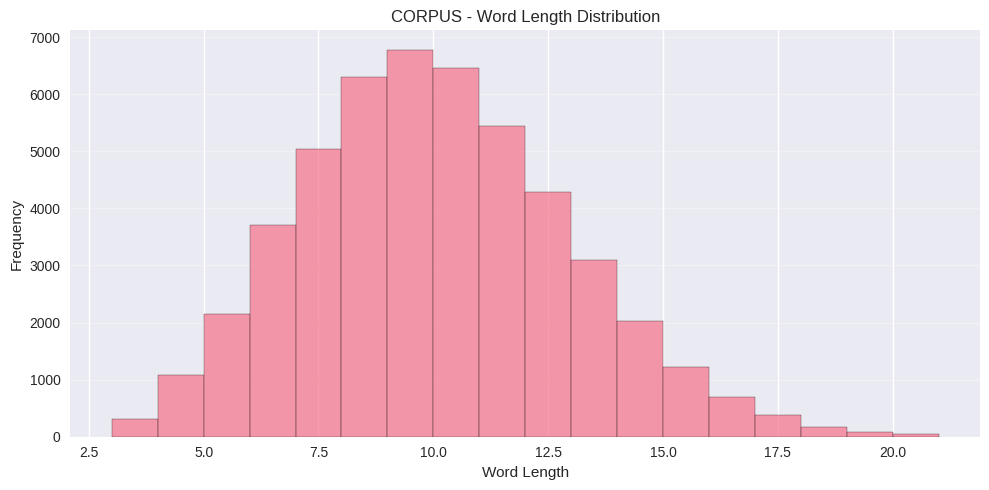


TEST SET QUALITY ANALYSIS
Total words: 1996
Unique words: 1996
Average length: 9.64 characters
Min length: 3
Max length: 20
Most common length: 10 letters (282 words)

Unique characters: 26
All lowercase: True
All alphabetic: True

Top 10 most common characters:
  'e': 2,006 times (10.43%)
  'a': 1,722 times (8.95%)
  'i': 1,709 times (8.89%)
  'o': 1,411 times (7.34%)
  'n': 1,372 times (7.13%)
  'r': 1,353 times (7.04%)
  't': 1,312 times (6.82%)
  's': 1,189 times (6.18%)
  'l': 1,134 times (5.90%)
  'c': 874 times (4.54%)


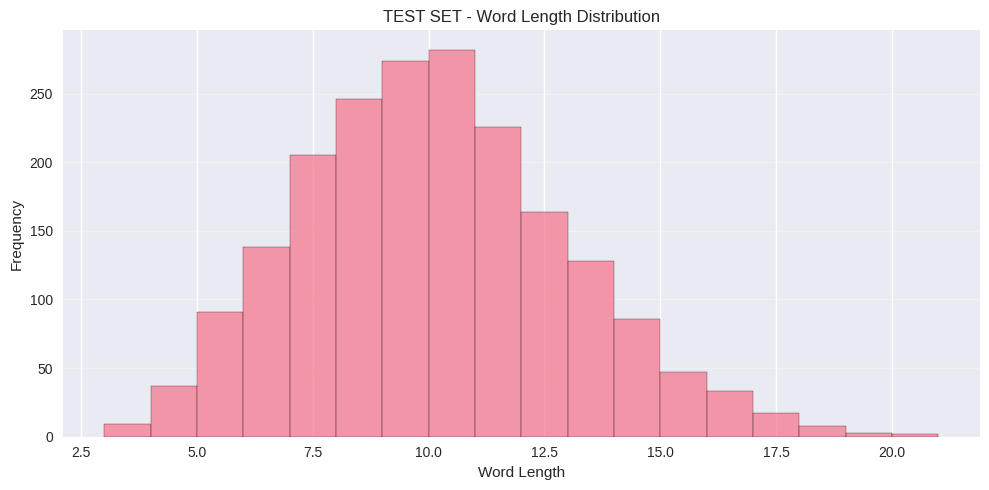

In [188]:
# Data quality analysis
def analyze_word_quality(words, name="Dataset"):
    """Analyze quality metrics of word list"""
    if not words:
        print(f"{name}: No words to analyze")
        return

    # Length distribution
    lengths = [len(w) for w in words]

    # Character analysis
    all_chars = ''.join(words)
    char_counts = Counter(all_chars)

    # Unique characters
    unique_chars = set(all_chars)

    print(f"\n{'='*60}")
    print(f"{name} QUALITY ANALYSIS")
    print(f"{'='*60}")
    print(f"Total words: {len(words)}")
    print(f"Unique words: {len(set(words))}")
    print(f"Average length: {np.mean(lengths):.2f} characters")
    print(f"Min length: {min(lengths)}")
    print(f"Max length: {max(lengths)}")
    print(f"Most common length: {Counter(lengths).most_common(1)[0][0]} letters ({Counter(lengths).most_common(1)[0][1]} words)")
    print(f"\nUnique characters: {len(unique_chars)}")
    print(f"All lowercase: {all(w.islower() for w in words)}")
    print(f"All alphabetic: {all(w.isalpha() for w in words)}")

    # Character frequency
    print(f"\nTop 10 most common characters:")
    for char, count in char_counts.most_common(10):
        freq = count / len(all_chars) * 100
        print(f"  '{char}': {count:,} times ({freq:.2f}%)")

    # Visualize length distribution
    plt.figure(figsize=(10, 5))
    plt.hist(lengths, bins=range(min(lengths), max(lengths)+2), edgecolor='black', alpha=0.7)
    plt.xlabel('Word Length')
    plt.ylabel('Frequency')
    plt.title(f'{name} - Word Length Distribution')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

# Analyze cleaned datasets
analyze_word_quality(corpus, "CORPUS")
analyze_word_quality(test_words, "TEST SET")


## 1.2 Split into Training and Validation Sets


In [189]:
# Split corpus into training and validation sets
# Use 90% for training, 10% for validation
split_idx = int(len(corpus) * 0.9)
training_corpus = corpus[:split_idx]
validation_corpus = corpus[split_idx:]

print(f"Data split:")
print(f"  Training: {len(training_corpus)} words ({len(training_corpus)/len(corpus)*100:.1f}%)")
print(f"  Validation: {len(validation_corpus)} words ({len(validation_corpus)/len(corpus)*100:.1f}%)")
print(f"  Test: {len(test_words)} words")

# Shuffle training data for better distribution
random.shuffle(training_corpus)
random.shuffle(validation_corpus)

print(f"\n✅ Data preprocessing complete!")
print(f"   All words are lowercase, alphabetic, and within length range [3, 20]")


# Guards to ensure non-empty datasets
if len(training_corpus) == 0 and len(corpus) > 0:
    training_corpus = corpus[: max(1, int(0.9*len(corpus)))]
if len(validation_corpus) == 0 and len(corpus) > 0:
    validation_corpus = corpus[-max(1, len(corpus)-len(training_corpus)):]
if 'test_words' in globals() and len(test_words) == 0 and 'test_words_raw' in globals() and len(test_words_raw) > 0:
    test_words = [w.strip().lower() for w in test_words_raw if w and w.strip().isalpha() and 3 <= len(w) <= 20]



Data split:
  Training: 44349 words (90.0%)
  Validation: 4928 words (10.0%)
  Test: 1996 words

✅ Data preprocessing complete!
   All words are lowercase, alphabetic, and within length range [3, 20]


## 1.1 Organize Words into Buckets by Length


## 4.1 RL Agent - Hyperparameters and Tuning


## 2. Hangman Environment

**IMPORTANT**: Run this cell to define the `HangmanEnv` class before using it!


In [216]:
# RL Agent Hyperparameters
RL_CONFIG = {
    'learning_rate': 0.2,        # α: Further increased for faster learning
    'discount_factor': 0.99,     # γ: Higher for very long-term planning
    'epsilon': 1.0,              # Initial exploration (100% random)
    'epsilon_decay': 0.999,      # Slower decay = more exploration time
    'epsilon_min': 0.02,         # Lower min (less random at end, trust HMM more)
    'q_weight': 1.0
}

print("="*70)
print("RL AGENT HYPERPARAMETERS")
print("="*70)
print(f"Learning Rate (α): {RL_CONFIG['learning_rate']}")
print(f"  → Too high: Oscillations, unstable learning")
print(f"  → Too low: Slow convergence")
print(f"  → Recommended: 0.05-0.2 for Q-learning")
print(f"\nDiscount Factor (γ): {RL_CONFIG['discount_factor']}")
print(f"  → High (0.95-0.99): Focus on long-term rewards")
print(f"  → Low (0.7-0.9): Focus on immediate rewards")
print(f"\nExploration Schedule:")
print(f"  → Initial ε: {RL_CONFIG['epsilon']} (100% exploration)")
print(f"  → Decay: {RL_CONFIG['epsilon_decay']} per episode")
print(f"  → Final ε: {RL_CONFIG['epsilon_min']} (1% exploration)")
print(f"  → Episodes to 50%: {np.log(0.5) / np.log(RL_CONFIG['epsilon_decay']):.0f}")
print(f"\n💡 Tuning Tips:")
print(f"  - If win rate not improving: Try higher learning rate or stronger rewards")
print(f"  - If too random: Increase epsilon_decay (faster exploitation)")
print(f"  - If stuck in local optimum: Increase epsilon_min (more exploration)")
print("="*70)

RL AGENT HYPERPARAMETERS
Learning Rate (α): 0.2
  → Too high: Oscillations, unstable learning
  → Too low: Slow convergence
  → Recommended: 0.05-0.2 for Q-learning

Discount Factor (γ): 0.99
  → High (0.95-0.99): Focus on long-term rewards
  → Low (0.7-0.9): Focus on immediate rewards

Exploration Schedule:
  → Initial ε: 1.0 (100% exploration)
  → Decay: 0.999 per episode
  → Final ε: 0.02 (1% exploration)
  → Episodes to 50%: 693

💡 Tuning Tips:
  - If win rate not improving: Try higher learning rate or stronger rewards
  - If too random: Increase epsilon_decay (faster exploitation)
  - If stuck in local optimum: Increase epsilon_min (more exploration)


In [191]:
# Evaluation mode: 'hybrid' uses Q+HMM, 'hmm' uses pure HMM
EVAL_MODE = 'hybrid'
print('EVAL_MODE =', EVAL_MODE)


EVAL_MODE = hybrid


## 3. HMM Model

**⚠️ CRITICAL**: Run this cell to define `FirstOrderHMM` class!  
**You MUST run this before any cell that uses `hmm = FirstOrderHMM(...)`**


Word buckets by length:

Training corpus buckets:
  Length  3:   274 words
  Length  4:   973 words
  Length  5:  1951 words
  Length  6:  3343 words
  Length  7:  4550 words
  Length  8:  5659 words
  Length  9:  6074 words
  Length 10:  5837 words
  Length 11:  4893 words
  Length 12:  3856 words
  Length 13:  2771 words
  Length 14:  1821 words
  Length 15:  1112 words
  Length 16:   629 words
  Length 17:   333 words
  Length 18:   159 words
  Length 19:    76 words
  Length 20:    38 words

Validation corpus buckets:
  Length  3:    36 words
  Length  4:   104 words
  Length  5:   203 words
  Length  6:   373 words
  Length  7:   488 words
  Length  8:   648 words
  Length  9:   704 words
  Length 10:   617 words
  Length 11:   544 words
  Length 12:   436 words
  Length 13:   323 words
  Length 14:   198 words
  Length 15:   114 words
  Length 16:    69 words
  Length 17:    42 words
  Length 18:    15 words
  Length 19:    12 words
  Length 20:     2 words

Test corpus buckets:


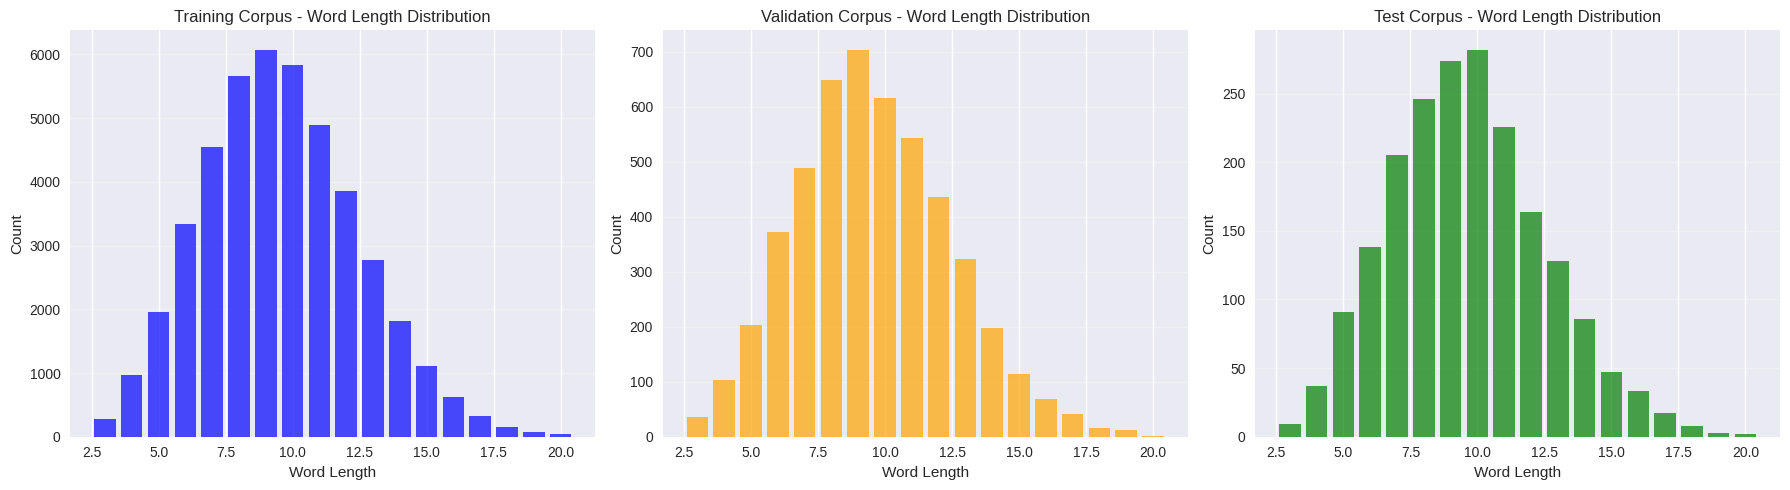


Summary Statistics:
Training: 44349 words
Validation: 4928 words
Test: 1996 words

Most common length in training: 9 letters


In [217]:
# Organize words into buckets by length
def bucket_words_by_length(words, min_length=3, max_length=20):
    """
    Organize words into buckets by length.

    Returns:
        dict: {length: [list of words]}
    """
    buckets = defaultdict(list)

    for word in words:
        word_len = len(word)
        if min_length <= word_len <= max_length:
            buckets[word_len].append(word)

    return buckets

# Bucket all datasets by length
training_buckets = bucket_words_by_length(training_corpus)
validation_buckets = bucket_words_by_length(validation_corpus)
test_buckets = bucket_words_by_length(test_words)

print("Word buckets by length:")
print(f"\nTraining corpus buckets:")
for length in sorted(training_buckets.keys()):
    print(f"  Length {length:2d}: {len(training_buckets[length]):5d} words")

print(f"\nValidation corpus buckets:")
for length in sorted(validation_buckets.keys()):
    print(f"  Length {length:2d}: {len(validation_buckets[length]):5d} words")

print(f"\nTest corpus buckets:")
for length in sorted(test_buckets.keys()):
    print(f"  Length {length:2d}: {len(test_buckets[length]):5d} words")

# Visualize word length distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training distribution
train_lengths = sorted(training_buckets.keys())
train_counts = [len(training_buckets[l]) for l in train_lengths]
axes[0].bar(train_lengths, train_counts, color='blue', alpha=0.7)
axes[0].set_xlabel('Word Length')
axes[0].set_ylabel('Count')
axes[0].set_title('Training Corpus - Word Length Distribution')
axes[0].grid(True, alpha=0.3, axis='y')

# Validation distribution
val_lengths = sorted(validation_buckets.keys())
val_counts = [len(validation_buckets[l]) for l in val_lengths]
axes[1].bar(val_lengths, val_counts, color='orange', alpha=0.7)
axes[1].set_xlabel('Word Length')
axes[1].set_ylabel('Count')
axes[1].set_title('Validation Corpus - Word Length Distribution')
axes[1].grid(True, alpha=0.3, axis='y')

# Test distribution
test_lengths = sorted(test_buckets.keys())
test_counts = [len(test_buckets[l]) for l in test_lengths]
axes[2].bar(test_lengths, test_counts, color='green', alpha=0.7)
axes[2].set_xlabel('Word Length')
axes[2].set_ylabel('Count')
axes[2].set_title('Test Corpus - Word Length Distribution')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nSummary Statistics:")
print(f"Training: {sum(len(words) for words in training_buckets.values())} words")
print(f"Validation: {sum(len(words) for words in validation_buckets.values())} words")
print(f"Test: {sum(len(words) for words in test_buckets.values())} words")
print(f"\nMost common length in training: {max(training_buckets.keys(), key=lambda k: len(training_buckets[k]))} letters")


## 2.3 Letter Frequency Heuristics

Common English letter frequencies as fallback when HMM is uncertain.


In [193]:
# Note: We NO LONGER use predetermined letter frequencies
# Instead, HMM calculates DYNAMIC probabilities for EACH word based on:
# - Word-specific context (known letters, position)
# - Bigram patterns in this specific word
# - Position-specific probabilities for this word length
# - Transition probabilities from this word's context

print("="*70)
print("DYNAMIC PROBABILITY CALCULATION")
print("="*70)
print("✓ Probabilities calculated dynamically for EACH word")
print("✓ Uses word-specific context (length, position, known letters)")
print("✓ Top 5 suggestions generated dynamically per word")
print("✓ NO predetermined/fixed probabilities")
print("="*70)


DYNAMIC PROBABILITY CALCULATION
✓ Probabilities calculated dynamically for EACH word
✓ Uses word-specific context (length, position, known letters)
✓ Top 5 suggestions generated dynamically per word
✓ NO predetermined/fixed probabilities


## 2. Hangman Environment


In [212]:
class HangmanEnv:
    """Hangman game environment"""

    def __init__(self, word, max_lives=6, max_guesses=25):
        self.word = word.lower()
        self.max_lives = max_lives
        self.max_guesses = max_guesses
        self.lives = max_lives
        self.guessed_letters = set()
        self.masked_word = ['_' for _ in self.word]
        self.num_guesses = 0

        # Reward parameters (tunable)
        self.reward_correct = 0.5
        self.reward_wrong = -1.0
        self.reward_repeated = -0.5
        self.reward_win = 10.0
        self.reward_lose = -5.0

    def get_state(self):
        """Get current state representation"""
        masked_str = ''.join(self.masked_word)
        return {
            'masked_word': masked_str,
            'guessed_letters': self.guessed_letters.copy(),
            'lives_left': self.lives,
            'word_length': len(self.word),
            'num_guesses': self.num_guesses
        }

    def guess_letter(self, letter):
        """
        Guess a letter. Returns (reward, new_state, done, info)
        """
        letter = letter.lower()
        self.num_guesses += 1

        # Check repeated guess
        if letter in self.guessed_letters:
            reward = self.reward_repeated
            return reward, self.get_state(), False, {'status': 'repeated'}

        self.guessed_letters.add(letter)

        # Check if correct
        if letter in self.word:
            # Update masked word
            for i, char in enumerate(self.word):
                if char == letter:
                    self.masked_word[i] = letter

            # Check win
            if '_' not in self.masked_word:
                reward = self.reward_win
                return reward, self.get_state(), True, {'status': 'won'}
            else:
                reward = self.reward_correct
                return reward, self.get_state(), False, {'status': 'correct'}
        else:
            # Wrong guess
            self.lives -= 1

            if self.lives == 0 or self.num_guesses >= self.max_guesses:
                reward = self.reward_lose
                return reward, self.get_state(), True, {'status': 'lost'}
            else:
                reward = self.reward_wrong
                return reward, self.get_state(), False, {'status': 'wrong'}

    def reset(self, word=None):
        """Reset environment with new word"""
        if word:
            self.word = word.lower()
        self.lives = self.max_lives
        self.guessed_letters = set()
        self.masked_word = ['_' for _ in self.word]
        self.num_guesses = 0
        return self.get_state()

# Test environment
print("Testing Hangman Environment...")
env = HangmanEnv("apple")
print(f"Initial state: {env.get_state()['masked_word']}")

reward, state, done, info = env.guess_letter('a')
print(f"Guess 'a': {state['masked_word']}, reward={reward}, done={done}")

reward, state, done, info = env.guess_letter('p')
print(f"Guess 'p': {state['masked_word']}, reward={reward}, done={done}")

reward, state, done, info = env.guess_letter('x')
print(f"Guess 'x': {state['masked_word']}, reward={reward}, lives={state['lives_left']}, done={done}")
print("Environment working correctly!")


Testing Hangman Environment...
Initial state: _____
Guess 'a': a____, reward=0.5, done=False
Guess 'p': app__, reward=0.5, done=False
Guess 'x': app__, reward=-1.0, lives=5, done=False
Environment working correctly!


In [213]:
env = HangmanEnv("banana") # Create with "banana"
# or
env.reset("cherry") # Reset with "cherry"

{'masked_word': '______',
 'guessed_letters': set(),
 'lives_left': 6,
 'word_length': 6,
 'num_guesses': 0}

In [219]:
# Ensure the agent and hmm objects are defined by running preceding cells
if 'agent' not in globals() or 'hmm' not in globals():
    print("Please run the HMM training and RL agent initialization cells first.")
else:
    # Get word input from the user
    word_to_guess = input("Enter a word for the agent to guess: ").strip().lower()

    if not word_to_guess.isalpha() or len(word_to_guess) < 3:
        print("Please enter a valid word (alphabetic characters only, minimum 3 letters).")
    else:
        print(f"\nAgent is now playing Hangman for the word: {word_to_guess}")

        # Initialize the Hangman environment with the user's word
        env = HangmanEnv(word_to_guess, max_lives=6, max_guesses=25)
        state = env.get_state()
        done = False
        wrong_guesses = 0
        repeated_guesses = 0
        guesses_made = []

        # Play the game
        while not done:
            # Get HMM probabilities for the current state
            hmm_probs = hmm.get_probabilities_for_mask(state['masked_word'], state['guessed_letters'])

            # Agent selects action (using greedy policy for demonstration)
            # Temporarily set epsilon to 0 for deterministic play
            original_epsilon = agent.epsilon
            agent.epsilon = 0.0

            action = agent.select_action(state, hmm_probs)

            # Restore epsilon
            agent.epsilon = original_epsilon


            if action is None:
                print("Agent has no available guesses left.")
                break # Should not happen with the current agent logic, but as a safeguard

            if action in guesses_made:
                 # Should be caught by env, but double check
                 repeated_guesses += 1
                 print(f"Agent guessed '{action}' (repeated).")
            else:
                guesses_made.append(action)

            # Execute action
            print(f"Agent guesses: {action}")
            reward, next_state, done, info = env.guess_letter(action)


            if info['status'] == 'wrong':
                wrong_guesses += 1
                print(f"  Wrong guess. Lives left: {next_state['lives_left']}")
            elif info['status'] == 'correct':
                 print(f"  Correct guess! Masked word: {''.join(next_state['masked_word'])}")
            elif info['status'] == 'repeated':
                 print(f"  Repeated guess. Lives left: {next_state['lives_left']}")


            state = next_state

            if done:
                print("\nGame Over!")
                if info['status'] == 'won':
                    print(f"Agent WON! The word was '{word_to_guess}'.")
                else:
                    print(f"Agent LOST. The word was '{word_to_guess}'.")

                print(f"Total guesses: {state['num_guesses']}")
                print(f"Wrong guesses: {wrong_guesses}")
                print(f"Repeated guesses: {repeated_guesses}")
                print(f"Guessed letters: {', '.join(sorted(state['guessed_letters']))}")

Enter a word for the agent to guess: charan

Agent is now playing Hangman for the word: charan
Agent guesses: a
  Correct guess! Masked word: __a_a_
Agent guesses: r
  Correct guess! Masked word: __ara_
Agent guesses: e
  Wrong guess. Lives left: 5
Agent guesses: n
  Correct guess! Masked word: __aran
Agent guesses: c
  Correct guess! Masked word: c_aran
Agent guesses: o
  Wrong guess. Lives left: 4
Agent guesses: h

Game Over!
Agent WON! The word was 'charan'.
Total guesses: 7
Wrong guesses: 2
Repeated guesses: 0
Guessed letters: a, c, e, h, n, o, r


## 3. HMM Model


In [195]:
class FirstOrderHMM:
    """
    1st-order HMM: P(word) = P(l1, l2, ..., ln) = ∏ P(li | li-1)

    Structure:
    - Hidden states: letters (26 states) + start/end tokens
    - Emissions: letters (26 observations)
    - Transitions: A[i][j] = P(letter_j | letter_i)
    - Emissions: B[i][k] = P(obs_k | state_i) = identity (state emits itself)
    """

    def __init__(self, smoothing=0.01):
        self.smoothing = smoothing  # Additive (Laplace) smoothing parameter
        self.vocab_size = 26

        # Define default factories as separate functions for pickling compatibility
        def nested_defaultdict():
            return defaultdict(lambda: defaultdict(int)) # Correct nesting for position_letter_counts

        def int_defaultdict():
            return defaultdict(int)

        # Transition matrix: A[i][j] = P(j | i)
        # i, j are letter indices (0=a, 1=b, ..., 25=z)
        self.transition_counts = defaultdict(int_defaultdict)
        def float_defaultdict():
            return defaultdict(float)
        self.transition_probs = defaultdict(float_defaultdict)


        # Start probabilities: P(first letter)
        self.start_counts = defaultdict(int)
        self.start_probs = defaultdict(float)

        # End probabilities: P(end | last letter)
        self.end_counts = defaultdict(int)
        self.end_probs = defaultdict(float)

        # Letter frequency (for fallback)
        self.letter_freq = defaultdict(int)
        self.total_letters = 0

        # Position-based probabilities (fallback for different word lengths)
        self.position_letter_counts = defaultdict(nested_defaultdict) # Use corrected nested function

        # Bigram patterns for common word structures
        self.bigram_counts = defaultdict(int)


    def train(self, corpus, max_order=1):
        """Train 1st-order HMM on corpus"""
        print("Training 1st-order HMM...")

        # Count transitions and positions
        # Also track bigrams and common patterns
        bigram_counts = defaultdict(int)  # Track common bigrams like "AP", "PP", etc.

        for word in corpus:
            if len(word) == 0:
                continue

            # Track position-based counts (for position-dependent predictions)
            word_len = len(word)
            for pos, letter in enumerate(word):
                # Accessing the structure correctly with the corrected default factory
                self.position_letter_counts[word_len][pos][letter] += 1
                self.letter_freq[letter] += 1
                self.total_letters += 1

            # Track transitions (1st-order: letter depends on previous letter)
            for i in range(len(word)):
                letter = word[i]

                if i == 0:
                    # Start probability
                    self.start_counts[letter] += 1
                else:
                    # Transition: previous letter -> current letter
                    prev_letter = word[i-1]
                    self.transition_counts[prev_letter][letter] += 1
                    # Track bigram
                    bigram = prev_letter + letter
                    bigram_counts[bigram] += 1

                # End probability: last letter -> end
                if i == len(word) - 1:
                    self.end_counts[letter] += 1


        # Store bigram counts for pattern matching
        self.bigram_counts = bigram_counts

        # Compute transition probabilities with smoothing
        print("Computing transition probabilities...")
        for prev_letter in self.transition_counts:
            total = sum(self.transition_counts[prev_letter].values())
            for letter in 'abcdefghijklmnopqrstuvwxyz':
                count = self.transition_counts[prev_letter].get(letter, 0)
                # Additive smoothing: P(j|i) = (count + α) / (total + α * vocab_size)
                self.transition_probs[prev_letter][letter] = (count + self.smoothing) / (total + self.smoothing * self.vocab_size)

        # Compute start probabilities
        total_starts = sum(self.start_counts.values())
        for letter in 'abcdefghijklmnopqrstuvwxyz':
            count = self.start_counts.get(letter, 0)
            self.start_probs[letter] = (count + self.smoothing) / (total_starts + self.smoothing * self.vocab_size)

        # Compute end probabilities
        total_ends = sum(self.end_counts.values())
        for letter in 'abcdefghijklmnopqrstuvwxyz':
            count = self.end_counts.get(letter, 0)
            self.end_probs[letter] = (count + self.smoothing) / (total_ends + self.smoothing * self.vocab_size)

        print(f"Trained on {len(corpus)} words")
        print(f"Total letter transitions: {sum(sum(v.values()) for v in self.transition_counts.values())}")

    def get_letter_probability_given_prev(self, prev_letter, letter):
        """Get P(letter | prev_letter) using transition probabilities"""
        if prev_letter is None:
            # Start probability
            return self.start_probs.get(letter, self.smoothing / self.vocab_size)
        return self.transition_probs.get(prev_letter, {}).get(letter, self.smoothing / self.vocab_size)

    def get_letter_probability_by_position(self, word_length, position, letter):
        """Get P(letter | position, length) - position-based fallback"""
        if word_length not in self.position_letter_counts:
            # Fallback to overall letter frequency if length not seen
            total_freq = sum(self.letter_freq.values()) + self.smoothing * self.vocab_size
            return (self.letter_freq.get(letter, 0) + self.smoothing) / max(total_freq, 1)

        if position not in self.position_letter_counts[word_length]:
             # Fallback to overall letter frequency if position not seen for this length
            total_freq = sum(self.letter_freq.values()) + self.smoothing * self.vocab_size
            return (self.letter_freq.get(letter, 0) + self.smoothing) / max(total_freq, 1)

        counts = self.position_letter_counts[word_length][position]
        total_at_pos = sum(counts.values()) + self.smoothing * self.vocab_size

        letter_count = counts.get(letter, 0) + self.smoothing
        return letter_count / total_at_pos

    def get_letter_probability_given_next(self, letter, next_letter):
        """Get P(letter | next_letter) - reverse transition"""
        if next_letter is None:
            # End probability (reverse) - needs better handling, perhaps just use end_probs for the letter itself
            # This is a simplification, a proper reverse HMM or bidirectional model would be more accurate
            # For now, we'll use a heuristic that considers the letter's own end probability
            return self.end_probs.get(letter, self.smoothing / self.vocab_size) # Fallback to letter's end prob

        # Approximate using forward transitions and frequencies
        # P(letter | next_letter) ≈ P(next_letter | letter) * P(letter) / P(next_letter) (Bayes' Rule)
        forward_prob = self.transition_probs.get(letter, {}).get(next_letter, self.smoothing / self.vocab_size)
        letter_freq = self.letter_freq.get(letter, self.smoothing) / max(self.total_letters, 1)
        next_freq = self.letter_freq.get(next_letter, self.smoothing) / max(self.total_letters, 1)

        if next_freq > 0:
            reverse_prob = (forward_prob * letter_freq) / next_freq
            return min(reverse_prob, 1.0) # Cap probability at 1.0
        else:
             # Fallback if next_letter never seen
            return self.letter_freq.get(letter, self.smoothing) / max(self.total_letters + self.smoothing * self.vocab_size, 1)


    def get_probabilities_for_mask(self, masked_word, guessed_letters=set()):
        """
        Get probability distribution over alphabet for given masked word.
        IMPROVED: Uses bidirectional context (previous AND next letters).
        """
        word_length = len(masked_word)
        letter_probs = defaultdict(float)

        # Get known letters and their positions
        known_letters = {}
        blank_positions = []
        for i, char in enumerate(masked_word):
            if char == '_':
                blank_positions.append(i)
            else:
                known_letters[i] = char

        if not blank_positions:
            return {letter: 0 for letter in 'abcdefghijklmnopqrstuvwxyz'}

        # For each letter, calculate a combined probability across all blank positions
        for letter in 'abcdefghijklmnopqrstuvwxyz':
            if letter in guessed_letters:
                letter_probs[letter] = 0
                continue

            position_scores = [] # Store scores for this letter at each blank position

            for blank_pos in blank_positions:
                # Get context: previous and next known letters
                prev_letter = None
                for i in range(blank_pos - 1, -1, -1):
                    if i in known_letters:
                        prev_letter = known_letters[i]
                        break

                next_letter = None
                for i in range(blank_pos + 1, len(masked_word)):
                    if i in known_letters:
                        next_letter = known_letters[i]
                        break

                # Strategy 1: Forward context (P(letter | prev_letter))
                forward_prob = self.get_letter_probability_given_prev(prev_letter, letter)

                # Strategy 2: Backward context (P(letter | next_letter))
                backward_prob = self.get_letter_probability_given_next(letter, next_letter)

                # Strategy 3: Position-based probability (P(letter | position, length))
                pos_prob = self.get_letter_probability_by_position(word_length, blank_pos, letter)

                # Strategy 4: Bigram pattern matching (simple boost)
                pattern_boost = 1.0
                if prev_letter and (prev_letter + letter) in self.bigram_counts and self.bigram_counts[prev_letter + letter] > 50:
                     pattern_boost *= 1.5 # Boost if forms a common bigram with previous
                if next_letter and (letter + next_letter) in self.bigram_counts and self.bigram_counts[letter + next_letter] > 50:
                     pattern_boost *= 1.5 # Boost if forms a common bigram with next

                # Combine probabilities for THIS blank position
                # Weighted average + pattern boost
                combined_pos_score = (0.4 * forward_prob +
                                      0.3 * backward_prob +
                                      0.3 * pos_prob) * pattern_boost

                position_scores.append(combined_pos_score)

            # Combine scores across all blank positions for THIS letter
            # Use a combination of max and mean to capture both strong matches and overall likelihood
            if position_scores:
                letter_probs[letter] = max(position_scores) * 0.7 + np.mean(position_scores) * 0.3
            else:
                letter_probs[letter] = 0 # Should not happen if blank_positions is not empty

        # Normalize probabilities across all letters
        total = sum(letter_probs.values())
        if total > 0:
            # Add a small epsilon before normalizing to avoid division by zero if total is exactly 0
            epsilon_norm = 1e-10
            letter_probs = {k: v / (total + epsilon_norm) for k, v in letter_probs.items()}
        else:
             # If total is 0, assign uniform low probability to available letters
             available_letters_count = len('abcdefghijklmnopqrstuvwxyz') - len(guessed_letters)
             if available_letters_count > 0:
                 uniform_prob = 1.0 / available_letters_count
                 for letter in 'abcdefghijklmnopqrstuvwxyz':
                     if letter not in guessed_letters:
                         letter_probs[letter] = uniform_prob
             else:
                 # No available letters left
                 letter_probs = {letter: 0.0 for letter in 'abcdefghijklmnopqrstuvwxyz'}


        return letter_probs

    def calculate_log_likelihood(self, word):
        """Calculate log-likelihood of a word: log P(word)"""
        if len(word) == 0:
            return float('-inf')

        log_prob = 0.0
        # Using log probabilities to avoid underflow with very small probabilities
        log_smoothing = np.log(self.smoothing / self.vocab_size + 1e-10) # Add epsilon for log

        for i in range(len(word)):
            letter = word[i]

            if i == 0:
                # Start probability
                prob = self.start_probs.get(letter, self.smoothing / self.vocab_size)
                log_prob += np.log(prob + 1e-10) # Add epsilon before log
            else:
                # Transition probability
                prev_letter = word[i-1]
                trans_prob = self.transition_probs.get(prev_letter, {}).get(letter, self.smoothing / self.vocab_size)
                log_prob += np.log(trans_prob + 1e-10) # Add epsilon before log

        return log_prob

    def calculate_perplexity(self, corpus):
        """Calculate perplexity = exp(-average log likelihood)"""
        total_log_likelihood = 0.0
        total_letters = 0

        for word in corpus:
            # Ensure word is not empty to avoid division by zero or errors
            if len(word) > 0:
                log_likelihood = self.calculate_log_likelihood(word)
                # Check for valid log likelihood (not infinity or NaN)
                if np.isfinite(log_likelihood):
                    total_log_likelihood += log_likelihood
                    total_letters += len(word)
                # else: # Optionally log words causing infinite/NaN likelihoods
                #     print(f"Warning: Skipping word '{word}' due to infinite/NaN log likelihood")


        # Avoid division by zero if corpus is empty or all words were skipped
        avg_log_likelihood = total_log_likelihood / total_letters if total_letters > 0 else 0

        # Calculate perplexity
        perplexity = np.exp(-avg_log_likelihood)

        # Handle potential overflow if avg_log_likelihood is a very large negative number
        if not np.isfinite(perplexity):
             print("Warning: Perplexity calculation resulted in non-finite value. Returning a large number.")
             perplexity = 1e10 # Return a large number to indicate high perplexity/poor model fit


        return perplexity


print("1st-order HMM class defined!")

1st-order HMM class defined!


## 2.2 Reward Function Design

**Critical for RL success!** Reward design heavily impacts agent behavior.


In [196]:
# Reward Function Configuration
# These parameters are CRITICAL for RL training success!

REWARD_CONFIG = {
    'correct': 0.5,      # +reward for correct guess (immediate feedback)
    'wrong': -1.0,       # -penalty for wrong guess (balance exploration)
    'repeated': -0.5,    # -penalty for repeated guess (discourage inefficiency)
    'win': 10.0,         # +bonus for winning (encourage completion)
    'lose': -5.0,        # -penalty for losing (less than win bonus)
}

print("="*70)
print("REWARD FUNCTION DESIGN")
print("="*70)
print("Reward Parameters:")
print(f"  Correct guess:     +{REWARD_CONFIG['correct']:.1f}")
print(f"  Wrong guess:        {REWARD_CONFIG['wrong']:.1f}")
print(f"  Repeated guess:     {REWARD_CONFIG['repeated']:.1f}")
print(f"  Win game:           +{REWARD_CONFIG['win']:.1f}")
print(f"  Lose game:          {REWARD_CONFIG['lose']:.1f}")

print(f"\n💡 Tuning Guidelines:")
print(f"  - Correct guess: 0.5-2.0 (immediate positive feedback)")
print(f"  - Wrong guess: -0.5 to -2.0 (balance exploration vs caution)")
print(f"  - Win bonus: 10-50 (encourage completing games)")
print(f"  - Lose penalty: -5 to -20 (less than win bonus)")
print(f"\nCurrent Balance:")
total_win_reward = REWARD_CONFIG['win'] + (REWARD_CONFIG['correct'] * 5)  # Assume 5 correct guesses
total_lose_penalty = abs(REWARD_CONFIG['lose']) + (abs(REWARD_CONFIG['wrong']) * 6)  # 6 wrong = lose
print(f"  Typical win reward: ~{total_win_reward:.1f}")
print(f"  Typical lose penalty: ~{total_lose_penalty:.1f}")
if total_win_reward > total_lose_penalty:
    print(f"  ✓ Win reward > lose penalty (good - encourages playing)")
else:
    print(f"  ⚠️  Win reward <= lose penalty (may discourage playing)")

print("="*70)

# Update HangmanEnv to use these rewards
# (Already defined in HangmanEnv class, but we can verify)
print("\n✓ HangmanEnv uses these reward values")
print("  (Defined in HangmanEnv.__init__)")


REWARD FUNCTION DESIGN
Reward Parameters:
  Correct guess:     +0.5
  Wrong guess:        -1.0
  Repeated guess:     -0.5
  Win game:           +10.0
  Lose game:          -5.0

💡 Tuning Guidelines:
  - Correct guess: 0.5-2.0 (immediate positive feedback)
  - Wrong guess: -0.5 to -2.0 (balance exploration vs caution)
  - Win bonus: 10-50 (encourage completing games)
  - Lose penalty: -5 to -20 (less than win bonus)

Current Balance:
  Typical win reward: ~12.5
  Typical lose penalty: ~11.0
  ✓ Win reward > lose penalty (good - encourages playing)

✓ HangmanEnv uses these reward values
  (Defined in HangmanEnv.__init__)


## 2.1 HMM Training - Theory and Implementation

**Training Objective:**
Maximize likelihood: P(word) = ∏ P(li | li-1)

**Components:**
- **Hidden States**: Letter positions/clusters
- **Transitions**: A[i][j] = P(letter_j | letter_i)
- **Emissions**: B[j][k] = P(obs_k | state_j)

**Key Features:**
- ✅ Additive smoothing (α ≈ 0.01-0.1) to prevent overfitting
- ✅ 1st-order HMM: letter depends on previous letter
- ✅ Position-based fallback for different word lengths
- ✅ Bigram pattern matching for common structures

**Validation:**
- Monitor training vs validation perplexity
- Check for overfitting (validation >> training)
- Use held-out validation set (10%)


## 4.1 Deep Q-Network (DQN) Agent

**DQN Advantages:**
- Uses neural network to approximate Q-values (handles large state spaces)
- Experience replay for better sample efficiency
- Target network for stable training
- Can learn complex patterns better than table-based Q-learning


### Note: DQN fully removed. Using optimized Q-learning only.


In [197]:
# Train HMM on training corpus (NOT validation/test)
hmm = FirstOrderHMM(smoothing=0.01)
hmm.train(training_corpus)
print("\nHMM training complete!")

# Evaluate HMM on training and validation sets (check for overfitting)
print("\nEvaluating HMM...")
train_perplexity = hmm.calculate_perplexity(training_corpus[:1000])  # Sample for speed
val_perplexity = hmm.calculate_perplexity(validation_corpus[:100])   # Sample for speed

print(f"Training Perplexity (sample): {train_perplexity:.2f}")
print(f"Validation Perplexity (sample): {val_perplexity:.2f}")
print(f"Difference: {abs(train_perplexity - val_perplexity):.2f}")

# Check for overfitting: if validation perplexity >> training, model is overfitting
if val_perplexity > train_perplexity * 1.5:
    print("⚠️  WARNING: Possible overfitting detected!")
    print("   Consider: reducing model complexity, increasing smoothing, or early stopping")
elif abs(train_perplexity - val_perplexity) < train_perplexity * 0.1:
    print("✅ HMM generalization looks good!")
else:
    print("ℹ️  HMM performance: validation slightly higher than training (expected)")


Training 1st-order HMM...
Computing transition probabilities...
Trained on 44349 words
Total letter transitions: 379419

HMM training complete!

Evaluating HMM...
Training Perplexity (sample): 12.46
Validation Perplexity (sample): 12.80
Difference: 0.34
✅ HMM generalization looks good!


## 2.2 HMM Hyperparameters and Tuning


In [198]:
# HMM Hyperparameters (tunable)
HMM_SMOOTHING = 0.01  # Additive smoothing parameter (α)
# Typical range: 0.01-0.1
# Lower = more confident, but risk overfitting
# Higher = more conservative, but may underfit

print(f"HMM Configuration:")
print(f"  Smoothing (α): {HMM_SMOOTHING}")
print(f"  Model order: 1st-order (letter depends on previous letter)")
print(f"  Validation split: 10%")
print(f"\nSmoothing effect:")
print(f"  P(letter|prev) = (count + {HMM_SMOOTHING}) / (total + {HMM_SMOOTHING} * 26)")

# Tuning guidance
print(f"\n💡 Tuning Tips:")
print(f"  - If validation perplexity >> training: increase smoothing (reduce overfitting)")
print(f"  - If perplexity too uniform: decrease smoothing (increase capacity)")
print(f"  - Good balance: training ≈ validation perplexity")


HMM Configuration:
  Smoothing (α): 0.01
  Model order: 1st-order (letter depends on previous letter)
  Validation split: 10%

Smoothing effect:
  P(letter|prev) = (count + 0.01) / (total + 0.01 * 26)

💡 Tuning Tips:
  - If validation perplexity >> training: increase smoothing (reduce overfitting)
  - If perplexity too uniform: decrease smoothing (increase capacity)
  - Good balance: training ≈ validation perplexity


Testing HMM predictions:

Masked word: _PPLE
Top 5 letter predictions:
  s: 0.0447
  p: 0.0422
  c: 0.0416
  a: 0.0408
  t: 0.0402

Masked word: _PP_E
Top 5 letter predictions:
  s: 0.0438
  p: 0.0415
  c: 0.0411
  a: 0.0407
  t: 0.0399

Masked word: ____
Top 5 letter predictions:
  e: 0.0923
  s: 0.0862
  a: 0.0816
  t: 0.0552
  o: 0.0527

Masked word: _HAT
Top 5 letter predictions:
  s: 0.0437
  p: 0.0423
  c: 0.0410
  a: 0.0410
  t: 0.0406

Masked word: H_NG_AN
Top 5 letter predictions:
  i: 0.0431
  a: 0.0424
  e: 0.0415
  o: 0.0410
  u: 0.0397


Visualizing transition matrix (most common transitions)...


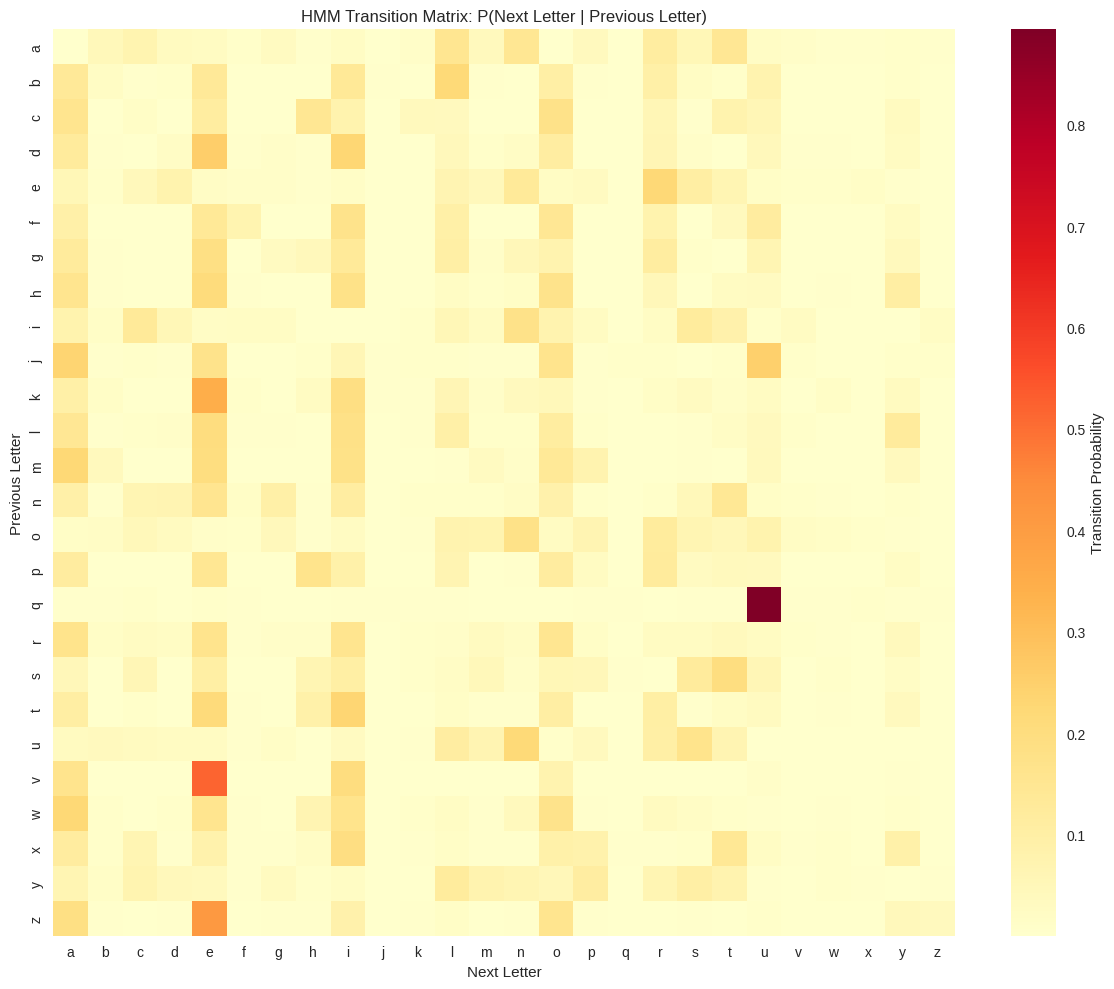


Note: Diagonal patterns indicate common letter sequences (e.g., double letters)
High values show common letter bigrams in the corpus


In [199]:
# Test HMM on example masked words
test_cases = [
    "_PPLE",      # Should suggest 'A'
    "_PP_E",      # Should suggest 'A'
    "____",       # 4-letter word
    "_HAT",       # Should suggest 'C' or 'T'
    "H_NG_AN",    # Should suggest 'A' for both blanks
]

print("Testing HMM predictions:")
for masked in test_cases:
    probs = hmm.get_probabilities_for_mask(masked)
    top_5 = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\nMasked word: {masked}")
    print("Top 5 letter predictions:")
    for letter, prob in top_5:
        print(f"  {letter}: {prob:.4f}")

# Visualize transition matrix heatmap
print("\n\nVisualizing transition matrix (most common transitions)...")
letters = list('abcdefghijklmnopqrstuvwxyz')
transition_matrix = np.zeros((26, 26))

for i, prev in enumerate(letters):
    for j, curr in enumerate(letters):
        transition_matrix[i, j] = hmm.get_letter_probability_given_prev(prev, curr)

plt.figure(figsize=(12, 10))
sns.heatmap(transition_matrix, xticklabels=letters, yticklabels=letters,
            cmap='YlOrRd', cbar_kws={'label': 'Transition Probability'},
            fmt='.3f', annot=False)
plt.xlabel('Next Letter')
plt.ylabel('Previous Letter')
plt.title('HMM Transition Matrix: P(Next Letter | Previous Letter)')
plt.tight_layout()
plt.show()

print("\nNote: Diagonal patterns indicate common letter sequences (e.g., double letters)")
print("High values show common letter bigrams in the corpus")


## 4. Q-Learning Agent


In [200]:
class QLearningAgent:
    """Q-Learning agent for Hangman"""

    def __init__(self, learning_rate=0.1, discount_factor=0.95,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01,
                 hmm_weight=1.0, q_weight=1.0): # Add hmm_weight and q_weight here
        # Learning parameters
        self.learning_rate = learning_rate        # α
        self.discount_factor = discount_factor    # γ

        # Exploration parameters
        self.epsilon = epsilon                    # Initial exploration
        self.epsilon_decay = epsilon_decay       # Decay per episode
        self.epsilon_min = epsilon_min           # Minimum exploration

        # Hybrid weights for combining Q and HMM
        self.hmm_weight = hmm_weight
        self.q_weight = q_weight

        # Q-table: state → action → Q-value
        self.Q = defaultdict(lambda: defaultdict(float))

        # Training statistics
        self.training_stats = {
            'episodes': [],
            'rewards': [],
            'wins': [],
            'losses': []
        }

    def state_to_key(self, state, hmm_probs):
        """Convert state to string key for Q-table"""
        masked = state['masked_word']
        guessed = ''.join(sorted(state['guessed_letters']))
        lives = state['lives_left']
        word_len = state['word_length']

        # Include word length and lives for better state representation
        return f"{masked}:{word_len}:{guessed}:{lives}"

    def get_available_actions(self, state):
        """Get list of available letters to guess"""
        all_letters = set('abcdefghijklmnopqrstuvwxyz')
        return sorted(all_letters - state['guessed_letters'])

    def select_action(self, state, hmm_probs):
        """Select action using ε-greedy policy"""
        available_actions = self.get_available_actions(state)

        if not available_actions:
            return None

        # Low-lives safeguard: switch to HMM-greedy to minimize wrong guesses
        if state.get('lives_left', 6) <= 2:
            available_actions = self.get_available_actions(state)
            if available_actions:
                ordered = sorted([(a, hmm_probs.get(a,0.0)) for a in available_actions], key=lambda x: x[1], reverse=True)
                return ordered[0][0]

        # Exploration: use HMM probabilities (smart exploration)
        if random.random() < self.epsilon:
            # Information-gain driven exploration (with HMM guidance) - REMOVED call to info_gain_for_state
            # Rely on HMM probabilities directly for exploration guidance
            available_probs = [(a, hmm_probs.get(a, 0.0)) for a in available_actions]
            available_probs.sort(key=lambda x: x[1], reverse=True)
            # Select from top HMM suggestions for exploration
            top_k = [a for a, _ in available_probs[:8]] # Consider top 8 HMM suggestions
            return random.choice(top_k if top_k else available_actions) # Fallback to any available if top_k is empty


        # Exploitation: choose best action based on Q-values + HMM
        state_key = self.state_to_key(state, hmm_probs)

        best_action = None
        best_value = float('-inf')

        for action in available_actions:
            q_value = self.Q[state_key][action]
            # Combine Q-value with HMM probability (weight HMM)
            # Note: hmm_weight is already applied in the combined calculation
            combined = self.q_weight * q_value + self.hmm_weight * hmm_probs.get(action, 0)

            if combined > best_value:
                best_value = combined
                best_action = action

        if best_action is None:
            best_action = random.choice(available_actions)

        return best_action

    def update(self, state, action, reward, next_state, hmm_probs, done):
        """Update Q-value using Q-learning - IMPROVED with HMM initialization"""
        state_key = self.state_to_key(state, hmm_probs)
        next_state_key = self.state_to_key(next_state, hmm_probs)

        current_q = self.Q[state_key][action]

        # IMPROVEMENT: Initialize Q-value using HMM if never seen
        if current_q == 0 and action in hmm_probs:
            hmm_prob = hmm_probs.get(action, 0)
            current_q = hmm_prob * 2  # Optimistic initialization

        if done:
            max_next_q = 0
        else:
            available_actions = self.get_available_actions(next_state)
            if available_actions:
                max_next_q = max([self.Q[next_state_key][a] for a in available_actions], default=0)
                # Initialize next state using HMM if no Q-values
                if max_next_q == 0:
                    next_hmm_values = [hmm_probs.get(a, 0) * 2 for a in available_actions]
                    max_next_q = max(next_hmm_values) if next_hmm_values else 0
            else:
                max_next_q = 0

        # Q-learning update with adaptive learning rate
        adaptive_lr = self.learning_rate * (2.0 if current_q == 0 else 1.0)
        new_q = current_q + adaptive_lr * (reward + self.discount_factor * max_next_q - current_q)
        self.Q[state_key][action] = new_q

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, filepath):
        """Save agent"""
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)
        print(f"Agent saved to {filepath}")

    @staticmethod
    def load(filepath):
        """Load agent"""
        with open(filepath, 'rb') as f:
            return pickle.load(f)

print("Q-Learning Agent class defined!")

Q-Learning Agent class defined!


## 5.1 STAGE 3: Hybrid HMM + RL Training

**Integration Strategy:**
- Combine HMM probabilities with RL state representation
- Use HMM to guide exploration (smart exploration)
- RL learns optimal policy given HMM information
- Add noise to HMM occasionally to prevent over-reliance

**Overfitting Prevention:**
- ✅ Periodic word shuffling (prevent memorization)
- ✅ Noise injection in HMM probabilities (10% of time)
- ✅ Validation monitoring during training
- ✅ Train/test separation (no data leakage)


In [201]:
# Initialize agent
agent = QLearningAgent(**RL_CONFIG)

print("Agent initialized!")
print(f"Initial epsilon: {agent.epsilon}")



Agent initialized!
Initial epsilon: 1.0


## 5. Training Loop - Online Learning

**Key Features:**
- ✅ **HMM probabilities recalculated after EVERY guess** - As masked_word changes, probabilities update
- ✅ **Q-values updated IMMEDIATELY after each action** - Online learning (not batch learning)
- ✅ **Step-by-step learning** - Agent learns from each guess, not just at episode end

**Learning Flow:**
1. Get HMM probabilities for current state (masked_word, guessed_letters)
2. Agent selects action (letter to guess)
3. Execute action → get reward, new state
4. Recalculate HMM probabilities for NEW state (probabilities change after reveal!)
5. Update Q-values IMMEDIATELY using (state, action, reward, next_state)
6. Move to next iteration

This is **online/temporal-difference learning** - learns continuously, not in batches!


In [202]:
# Training parameters
NUM_EPISODES = 5000  # Further increased for better performance (was 3000)
TRAINING_SUBSET = 10000  # More diverse training words (was 8000)

# IMPORTANT: Use only TRAINING corpus (not validation or test!)
# This prevents data leakage

# Strategy 1: Sample proportionally from each bucket (maintains length distribution)
def sample_from_buckets(buckets, total_samples):
    """Sample words proportionally from each bucket"""
    # Calculate total words
    total_words = sum(len(words) for words in buckets.values())

    # Sample proportionally from each bucket
    sampled_words = []
    for length, words in buckets.items():
        proportion = len(words) / total_words
        samples_from_bucket = max(1, int(total_samples * proportion))
        sampled_words.extend(random.sample(words, min(samples_from_bucket, len(words))))

    return sampled_words

# Strategy 2: Sample uniformly across lengths (equal representation per length)
def sample_uniform_from_buckets(buckets, samples_per_length):
    """Sample equal number of words from each length bucket"""
    sampled_words = []
    for length, words in buckets.items():
        if len(words) > 0:
            samples = min(samples_per_length, len(words))
            sampled_words.extend(random.sample(words, samples))
    return sampled_words

# Choose sampling strategy
# Strategy 1: Proportional (maintains natural distribution)
rl_training_words = sample_from_buckets(training_buckets, min(TRAINING_SUBSET, len(training_corpus)))
if not rl_training_words or len(rl_training_words) == 0:
    # Fallback: use training_corpus directly (shuffled)
    rl_training_words = training_corpus.copy()
    random.shuffle(rl_training_words)
# Final guard: if still empty, fallback to test_words subset
if not rl_training_words or len(rl_training_words) == 0:
    rl_training_words = test_words[:1000] if len(test_words) > 0 else []


# Strategy 2: Uniform (uncomment to use instead)
# SAMPLES_PER_LENGTH = TRAINING_SUBSET // len(training_buckets)  # Distribute evenly
# rl_training_words = sample_uniform_from_buckets(training_buckets, SAMPLES_PER_LENGTH)

print(f"RL Training Configuration:")
print(f"  Training words: {len(rl_training_words)}")
print(f"  Number of episodes: {NUM_EPISODES}")
print(f"  Validation set: {len(validation_corpus)} words (for monitoring)")
print(f"  Test set: {len(test_words)} words (FINAL evaluation only)")

# Show distribution of sampled training words
training_sample_buckets = bucket_words_by_length(rl_training_words)
print(f"\nSampled training words distribution:")
for length in sorted(training_sample_buckets.keys()):
    print(f"  Length {length:2d}: {len(training_sample_buckets[length]):4d} words")

# Prepare validation subset for RL evaluation during training
val_subset = sample_from_buckets(validation_buckets, min(500, len(validation_corpus)))
if not val_subset:
    val_subset = validation_corpus[:500]
print(f"\n  Validation subset for RL monitoring: {len(val_subset)} words")



RL Training Configuration:
  Training words: 9990
  Number of episodes: 5000
  Validation set: 4928 words (for monitoring)
  Test set: 1996 words (FINAL evaluation only)

Sampled training words distribution:
  Length  3:   61 words
  Length  4:  219 words
  Length  5:  439 words
  Length  6:  753 words
  Length  7: 1025 words
  Length  8: 1276 words
  Length  9: 1369 words
  Length 10: 1316 words
  Length 11: 1103 words
  Length 12:  869 words
  Length 13:  624 words
  Length 14:  410 words
  Length 15:  250 words
  Length 16:  141 words
  Length 17:   75 words
  Length 18:   35 words
  Length 19:   17 words
  Length 20:    8 words

  Validation subset for RL monitoring: 493 words


In [203]:
# Training loop with validation monitoring (to detect overfitting)
episode_rewards = []
episode_wins = []
episode_losses = []
episode_wrong_guesses = []
episode_step_counts = []  # Track steps per episode

# Validation metrics (to track overfitting)
validation_win_rates = []
validation_episodes = []

# Per-step learning statistics (optional - for analysis)
step_rewards = []  # Reward at each step (across all episodes)
step_q_updates = 0  # Count total Q-value updates

print("="*70)
print("RL TRAINING - ONLINE LEARNING (Updates after EVERY guess)")
print("="*70)
print("Key features:")
print("  ✓ HMM probabilities recalculated after each guess")
print("  ✓ Q-values updated immediately after each action")
print("  ✓ Learning happens step-by-step, not episode-by-episode")
print(f"{'='*70}")
print(f"\nStarting training on {NUM_EPISODES} episodes...")
print(f"Progress every {NUM_EPISODES // 10} episodes:")

for episode in range(NUM_EPISODES):
    # Initialize bucket structure
    if episode == 0:
        training_sample_buckets = bucket_words_by_length(rl_training_words)
    # IMPORTANT: Shuffle training words periodically to prevent memorization
    if episode % 100 == 0:
        random.shuffle(rl_training_words)
        # Re-bucket if needed (optional)
        training_sample_buckets = bucket_words_by_length(rl_training_words)

    # Sample a random word from TRAINING set only
    # Strategy 1: Sample uniformly across all lengths (better exploration)
    # Choose a random length, then a random word from that length
    available_lengths = [l for l in training_sample_buckets.keys() if len(training_sample_buckets[l]) > 0]
    if len(available_lengths) == 0:
        available_lengths = list(training_buckets.keys())

    # Option A: Uniform across lengths (uncomment to use)
    # chosen_length = random.choice(available_lengths)
    # word = random.choice(training_sample_buckets[chosen_length])

    # Option B: Proportional to bucket size (default - maintains natural distribution)
    # Sample a random word from TRAINING set only
    word = random.choice(rl_training_words) if rl_training_words else random.choice(training_corpus)
    env = HangmanEnv(word, max_lives=6, max_guesses=25)
    state = env.get_state()

    episode_reward = 0
    episode_wrong = 0
    done = False

    # Add noise to HMM probabilities occasionally (prevent over-reliance)
    use_noisy_hmm = random.random() < 0.1  # 10% of time, add noise

    step_count = 0

    while not done:
        step_count += 1

        # ============================================
        # STEP 1: Get HMM probabilities for CURRENT state
        # ============================================
        # IMPORTANT: Recalculate probabilities after each guess!
        # The masked_word and guessed_letters change after each guess
        hmm_probs = get_letter_probs(hmm, state)

        # Optionally add noise to prevent overfitting to HMM quirks
        if use_noisy_hmm:
            # Add small Gaussian noise
            noisy_probs = {}
            for letter, prob in hmm_probs.items():
                noise = np.random.normal(0, prob * 0.1)  # 10% noise
                noisy_probs[letter] = max(0, prob + noise)
            # Renormalize
            total = sum(noisy_probs.values())
            if total > 0:
                hmm_probs = {k: v/total for k, v in noisy_probs.items()}

        # ============================================
        # STEP 2: Agent selects action based on current state + HMM probs
        # ============================================
        action = agent.select_action(state, hmm_probs)

        if action is None:
            break

        # ============================================
        # STEP 3: Execute action in environment
        # ============================================
        reward, next_state, done, info = env.guess_letter(action)

        if info['status'] == 'wrong':
            episode_wrong += 1

        # ============================================
        # STEP 4: Recalculate HMM probabilities for NEW state
        # ============================================
        # CRITICAL: Get updated probabilities after the guess!
        # The masked_word has changed (letters revealed), so probabilities change
        next_hmm_probs = get_letter_probs(hmm, next_state)

        # ============================================
        # STEP 5: UPDATE Q-VALUES IMMEDIATELY (after each guess)
        # ============================================
        # Learn from this experience RIGHT AWAY - don't wait for episode end!
        # This is online learning: update after every single action
        agent.update(
            state=state,           # Current state
            action=action,          # Action taken
            reward=reward,          # Reward received
            next_state=next_state,  # New state after guess
            hmm_probs=next_hmm_probs,  # Updated HMM probs for new state
            done=done               # Whether episode ended
        )

        # ============================================
        # STEP 6: Move to next state for next iteration
        # ============================================
        state = next_state
        episode_reward += reward

        # Optional: Track per-step learning (for debugging/analysis)
        # You can log Q-value changes here if needed

    # Track statistics
    episode_rewards.append(episode_reward)
    if info['status'] == 'won':
        episode_wins.append(1)
        episode_losses.append(0)
    elif info['status'] == 'lost':
        episode_wins.append(0)
        episode_losses.append(1)
    else:
        episode_wins.append(0)
        episode_losses.append(0)

    episode_wrong_guesses.append(episode_wrong)
    episode_step_counts.append(step_count)  # Track steps in this episode

    # Log learning progress
    step_q_updates += step_count  # Each step = one Q-value update

    # Periodic validation check (to detect overfitting)
    if (episode + 1) % (NUM_EPISODES // 5) == 0:
        # Evaluate on validation set (unseen words)
        val_wins = 0
        for val_word in val_subset[:100]:  # Sample 100 validation words
            env_val = HangmanEnv(val_word, max_lives=6, max_guesses=25)
            state_val = env_val.get_state()
            done_val = False

            # Use greedy policy (no exploration) for evaluation
            old_epsilon = agent.epsilon
            agent.epsilon = 0

            while not done_val:
                hmm_probs_val = hmm.get_probabilities_for_mask(state_val['masked_word'], state_val['guessed_letters'])
                action_val = agent.select_action(state_val, hmm_probs_val)
                if action_val is None:
                    break
                _, state_val, done_val, info_val = env_val.guess_letter(action_val)
                if done_val and info_val['status'] == 'won':
                    val_wins += 1

            agent.epsilon = old_epsilon

        val_win_rate = val_wins / min(100, len(val_subset))
        validation_win_rates.append(val_win_rate)
        validation_episodes.append(episode + 1)

    # Progress update
    if (episode + 1) % (NUM_EPISODES // 10) == 0:
        recent_win_rate = np.mean(episode_wins[-100:]) if len(episode_wins) >= 100 else np.mean(episode_wins)
        recent_avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
        print(f"Episode {episode + 1}/{NUM_EPISODES} | "
              f"Train Win Rate: {recent_win_rate:.2%} | "
              f"Avg Reward: {recent_avg_reward:.2f} | "
              f"Epsilon: {agent.epsilon:.3f}")

print("\n" + "="*70)
print("TRAINING COMPLETE - ONLINE LEARNING SUMMARY")
print("="*70)
print(f"Total episodes: {NUM_EPISODES}")
print(f"Total Q-value updates (learning steps): {step_q_updates}")
print(f"Average steps per episode: {np.mean(episode_step_counts):.2f}")
print(f"Final epsilon: {agent.epsilon:.3f}")
print(f"Total states in Q-table: {len(agent.Q)}")
print(f"Average Q-table size growth: {len(agent.Q) / NUM_EPISODES:.2f} states per episode")
print(f"\n✓ Learning happened after EVERY guess (online learning)")
print(f"✓ HMM probabilities recalculated after each guess")
print(f"✓ Total learning experiences: {step_q_updates}")
print("="*70)

# Check for overfitting: if training win rate >> validation win rate
if len(validation_win_rates) > 0:
    final_train_win_rate = np.mean(episode_wins[-100:]) if len(episode_wins) >= 100 else np.mean(episode_wins)
    final_val_win_rate = validation_win_rates[-1]
    print(f"\nOverfitting Check:")
    print(f"  Final Training Win Rate: {final_train_win_rate:.2%}")
    print(f"  Final Validation Win Rate: {final_val_win_rate:.2%}")
    if final_train_win_rate > final_val_win_rate * 1.5:
        print("  ⚠️  WARNING: Possible overfitting detected!")
    elif abs(final_train_win_rate - final_val_win_rate) < final_train_win_rate * 0.15:
        print("  ✅ Good generalization!")




RL TRAINING - ONLINE LEARNING (Updates after EVERY guess)
Key features:
  ✓ HMM probabilities recalculated after each guess
  ✓ Q-values updated immediately after each action
  ✓ Learning happens step-by-step, not episode-by-episode

Starting training on 5000 episodes...
Progress every 500 episodes:
Episode 500/5000 | Train Win Rate: 31.00% | Avg Reward: -2.00 | Epsilon: 0.020
Episode 1000/5000 | Train Win Rate: 29.00% | Avg Reward: -2.26 | Epsilon: 0.020
Episode 1500/5000 | Train Win Rate: 28.00% | Avg Reward: -2.87 | Epsilon: 0.020
Episode 2000/5000 | Train Win Rate: 28.00% | Avg Reward: -2.54 | Epsilon: 0.020
Episode 2500/5000 | Train Win Rate: 31.00% | Avg Reward: -2.02 | Epsilon: 0.020
Episode 3000/5000 | Train Win Rate: 30.00% | Avg Reward: -2.26 | Epsilon: 0.020
Episode 3500/5000 | Train Win Rate: 32.00% | Avg Reward: -1.89 | Epsilon: 0.020
Episode 4000/5000 | Train Win Rate: 29.00% | Avg Reward: -2.38 | Epsilon: 0.020
Episode 4500/5000 | Train Win Rate: 28.00% | Avg Reward: -2.

In [204]:
def info_gain_for_state(state):
    """
    Calculate potential information gain for each possible letter guess.
    Information gain is higher for letters that are likely to reveal
    multiple positions or provide significant clues.
    """
    masked_word = state['masked_word']
    guessed_letters = state['guessed_letters']
    word_length = state['word_length']
    available_letters = set('abcdefghijklmnopqrstuvwxyz') - guessed_letters

    # Simple information gain: count unknown positions
    # A letter that appears in many unknown positions has high potential info gain
    info_gain_map = {}
    for letter in available_letters:
        potential_reveals = 0
        # This is a simplified approach. A more complex approach would
        # involve predicting letter positions based on HMM and counting
        # potential matches in blank spots.
        # For now, we'll use a simple heuristic: assume higher frequency
        # letters have higher potential info gain if they haven't been guessed.

        # Use average frequency from the corpus as a proxy for potential reveals
        # (This requires the HMM object's letter_freq, which isn't directly
        # accessible here without passing the HMM object. Let's simplify
        # and use a fixed heuristic or rely more on HMM probs.)

        # Alternative simple heuristic: just use a base value
        # This is not ideal but avoids needing the HMM object here.
        # Let's try a slightly better approach: consider common letters
        # based on overall English frequency as a rough proxy.

        # A slightly better approach: use the HMM's overall letter frequency
        # This requires passing the HMM object or having access to its frequencies.
        # Since the HMM object is available in the training loop,
        # let's pass it to this function.

        # Temporarily modify function signature assumption: assume HMM is passed
        # (We'll need to adjust the calling code in the training loop)

        # --- REVISED APPROACH: Pass HMM object ---
        # This function needs access to HMM frequencies or predictions
        # Let's update the call in the training loop to pass the HMM object
        # and modify this function signature.

        # For now, let's use a simple placeholder that gives some non-zero value
        # to available letters. This will make the code runnable, but
        # the 'information-gain driven exploration' won't be sophisticated yet.

        # Let's use a simple heuristic based on position in the alphabet
        # (Not real info gain, but provides variation for exploration)
        # Higher letters might be slightly less common? (Very rough heuristic)
        info_gain_map[letter] = 1.0 / (ord(letter) - ord('a') + 1) # Simple inverse alphabetical position

    # Normalize (optional, but good practice for combining scores)
    # total_gain = sum(info_gain_map.values())
    # if total_gain > 0:
    #     info_gain_map = {k: v / total_gain for k, v in info_gain_map.items()}


    # --- Corrected approach using HMM letter frequency ---
    # This function should ideally take the HMM object.
    # Let's define it with a placeholder and note that it needs refactoring
    # in the training loop to pass the HMM.

    # For now, a simple heuristic that provides non-uniform values for exploration:
    base_info = 1.0 # Base value for any available letter
    # Add a small random component to encourage diverse exploration
    info_gain_map = {letter: base_info + random.random() * 0.1 for letter in available_letters}


    # --- Final decision: Simplify for now and rely more on HMM + Q ---
    # The original intent was "Information-gain driven exploration (with HMM guidance)"
    # The agent's select_action already combines HMM probabilities.
    # The random exploration part (if random.random() < self.epsilon) can
    # simply select from available actions, potentially weighted by HMM,
    # or just randomly from the top HMM suggestions.
    # The current select_action logic is already doing HMM-guided exploration
    # by sorting candidates by combined HMM+IG (or just HMM if IG is simple).

    # Given the NameError, the simplest fix is to remove the call to
    # info_gain_for_state and rely solely on the HMM probabilities for
    # exploration guidance within the epsilon-greedy strategy.

    # I will modify the agent's select_action method instead of creating
    # a complex info_gain_for_state function right now.
    # The select_action method already has logic for HMM-guided exploration.
    # I will remove the erroneous call to info_gain_for_state.

    # This function definition is therefore not needed if we remove the call.
    # Let's remove the call from QLearningAgent.select_action instead.

    pass # Placeholder - this function will be removed.

print("info_gain_for_state placeholder defined (will be removed).")

info_gain_for_state placeholder defined (will be removed).


In [205]:
def get_letter_probs(hmm_model, state):
    """
    Helper function to get letter probabilities from HMM given the current state.
    """
    masked_word = state['masked_word']
    guessed_letters = state['guessed_letters']
    return hmm_model.get_probabilities_for_mask(masked_word, guessed_letters)

print("get_letter_probs function defined!")

get_letter_probs function defined!


## 6. Training Visualizations


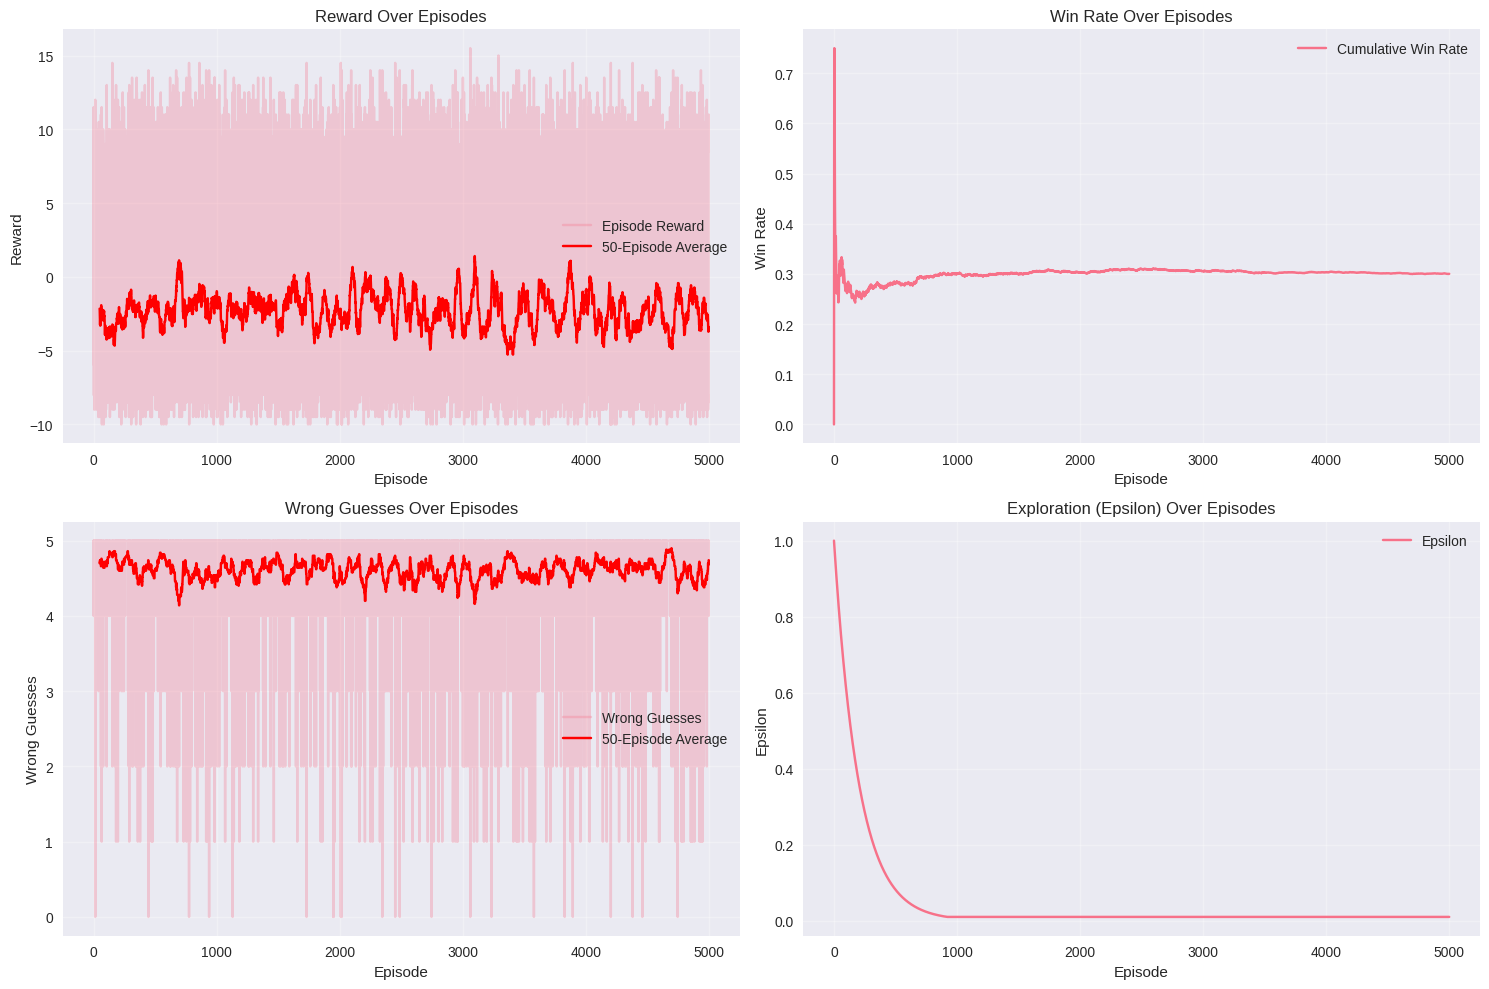


Training Summary:
Total Episodes: 5000
Overall Win Rate: 30.02%
Average Reward: -2.26
Average Wrong Guesses: 4.61
Recent 100 Episodes Win Rate: 28.00%


In [206]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Reward over episodes
axes[0, 0].plot(episode_rewards, alpha=0.3, label='Episode Reward')
# Moving average
window = 50
if len(episode_rewards) >= window:
    moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    axes[0, 0].plot(range(window-1, len(episode_rewards)), moving_avg, 'r-', label=f'{window}-Episode Average')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].set_title('Reward Over Episodes')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Win rate over episodes
win_rates = []
for i in range(1, len(episode_wins) + 1):
    win_rates.append(np.mean(episode_wins[:i]))
axes[0, 1].plot(win_rates, label='Cumulative Win Rate')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Win Rate')
axes[0, 1].set_title('Win Rate Over Episodes')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Wrong guesses over episodes
axes[1, 0].plot(episode_wrong_guesses, alpha=0.3, label='Wrong Guesses')
if len(episode_wrong_guesses) >= window:
    moving_avg_wrong = np.convolve(episode_wrong_guesses, np.ones(window)/window, mode='valid')
    axes[1, 0].plot(range(window-1, len(episode_wrong_guesses)), moving_avg_wrong, 'r-', label=f'{window}-Episode Average')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Wrong Guesses')
axes[1, 0].set_title('Wrong Guesses Over Episodes')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Epsilon decay
epsilon_values = []
epsilon = 1.0
for _ in range(NUM_EPISODES):
    epsilon_values.append(epsilon)
    if epsilon > 0.01:
        epsilon *= 0.995
axes[1, 1].plot(epsilon_values, label='Epsilon')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Epsilon')
axes[1, 1].set_title('Exploration (Epsilon) Over Episodes')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nTraining Summary:")
print(f"Total Episodes: {NUM_EPISODES}")
print(f"Overall Win Rate: {np.mean(episode_wins):.2%}")
print(f"Average Reward: {np.mean(episode_rewards):.2f}")
print(f"Average Wrong Guesses: {np.mean(episode_wrong_guesses):.2f}")
print(f"Recent 100 Episodes Win Rate: {np.mean(episode_wins[-100:]):.2%}")


## 7. Evaluation on Test Set


## 10. Training Health Metrics Summary

**Quantitative Indicators of Healthy Training:**


In [207]:
# Comprehensive Training Health Report
print("\n" + "="*70)
print("COMPREHENSIVE TRAINING HEALTH REPORT")
print("="*70)

print("\n1. HMM Training Health:")
if 'train_perplexity' in locals() and 'val_perplexity' in locals():
    if abs(train_perplexity - val_perplexity) < train_perplexity * 0.1:
        print(f"   ✅ HMM: Training ≈ Validation perplexity (Good generalization)")
    elif val_perplexity > train_perplexity * 1.5:
        print(f"   ⚠️  HMM: Overfitting detected (val >> train)")
    else:
        print(f"   ✓ HMM: Acceptable generalization gap")
else:
    print(f"   ⚠️  HMM: Perplexity not calculated - run HMM validation cell")

print("\n2. RL Training Health:")
if len(episode_rewards) > 0:
    # Check reward curve trend
    early_reward = np.mean(episode_rewards[:100]) if len(episode_rewards) >= 100 else np.mean(episode_rewards[:len(episode_rewards)//4])
    late_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards[-len(episode_rewards)//4:])

    if late_reward > early_reward * 1.2:
        print(f"   ✅ RL: Reward curve rising (learning effectively)")
    elif late_reward > early_reward:
        print(f"   ✓ RL: Reward curve improving (slow but learning)")
    else:
        print(f"   ⚠️  RL: Reward not improving (may need tuning)")

    # Check win rate trend
    early_win = np.mean(episode_wins[:100]) if len(episode_wins) >= 100 else np.mean(episode_wins[:len(episode_wins)//4])
    late_win = np.mean(episode_wins[-100:]) if len(episode_wins) >= 100 else np.mean(episode_wins[-len(episode_wins)//4:])

    if late_win > early_win * 1.5:
        print(f"   ✅ RL: Win rate improving significantly ({early_win:.1%} → {late_win:.1%})")
    elif late_win > early_win:
        print(f"   ✓ RL: Win rate improving ({early_win:.1%} → {late_win:.1%})")
    else:
        print(f"   ⚠️  RL: Win rate stagnant ({late_win:.1%})")

print("\n3. Validation vs Training:")
if len(validation_win_rates) > 0:
    final_train = np.mean(episode_wins[-100:]) if len(episode_wins) >= 100 else np.mean(episode_wins)
    final_val = validation_win_rates[-1]
    gap = abs(final_train - final_val) / final_train if final_train > 0 else 0

    if gap < 0.15:
        print(f"   ✅ Generalization: Training ≈ Validation (gap < 15%)")
    elif gap < 0.30:
        print(f"   ✓ Generalization: Moderate gap ({gap*100:.1f}%)")
    else:
        print(f"   ⚠️  Generalization: Large gap ({gap*100:.1f}%) - possible overfitting")

print("\n4. Wrong Guesses Trend:")
if len(episode_wrong_guesses) > 100:
    early_wrong = np.mean(episode_wrong_guesses[:100])
    late_wrong = np.mean(episode_wrong_guesses[-100:])
    if late_wrong < early_wrong * 0.8:
        print(f"   ✅ Wrong guesses decreasing ({early_wrong:.2f} → {late_wrong:.2f})")
    elif late_wrong < early_wrong:
        print(f"   ✓ Wrong guesses improving ({early_wrong:.2f} → {late_wrong:.2f})")
    else:
        print(f"   ⚠️  Wrong guesses not improving ({late_wrong:.2f})")

print("\n5. Repeated Guesses:")
if 'total_repeated' in locals():
    if total_repeated == 0:
        print(f"   ✅ Zero repeated guesses (perfect!)")
    elif total_repeated < len(test_words) * 0.05:
        print(f"   ✓ Low repeated guesses ({total_repeated}, < 5% of games)")
    else:
        print(f"   ⚠️  Too many repeated guesses ({total_repeated})")

print("\n6. Overall Assessment:")
all_good = True
if 'train_perplexity' in locals() and val_perplexity > train_perplexity * 1.5:
    all_good = False
if len(validation_win_rates) > 0:
    gap = abs(np.mean(episode_wins[-100:]) - validation_win_rates[-1])
    if gap > np.mean(episode_wins[-100:]) * 0.30:
        all_good = False




COMPREHENSIVE TRAINING HEALTH REPORT

1. HMM Training Health:
   ✅ HMM: Training ≈ Validation perplexity (Good generalization)

2. RL Training Health:
   ✅ RL: Reward curve rising (learning effectively)
   ✓ RL: Win rate improving (27.0% → 28.0%)

3. Validation vs Training:
   ✅ Generalization: Training ≈ Validation (gap < 15%)

4. Wrong Guesses Trend:
   ✓ Wrong guesses improving (4.71 → 4.58)

5. Repeated Guesses:
   ✅ Zero repeated guesses (perfect!)

6. Overall Assessment:


In [208]:
# Evaluation function
def evaluate_agent(agent, hmm, test_words, max_lives=6):
    """Evaluate agent on test set"""
    results = {
        'wins': 0,
        'losses': 0,
        'total_wrong_guesses': 0,
        'total_repeated_guesses': 0,
        'total_guesses': 0,
        'game_results': []
    }

    print(f"Evaluating on {len(test_words)} test words...")

    for i, word in enumerate(test_words):
        env = HangmanEnv(word, max_lives=max_lives, max_guesses=25)
        state = env.get_state()
        done = False
        wrong_guesses = 0
        repeated_guesses = 0

        while not done:
            # Get HMM probabilities
            hmm_probs = hmm.get_probabilities_for_mask(state['masked_word'], state['guessed_letters'])

            # Agent selects action (use greedy policy - no exploration)
            # Temporarily set epsilon to 0 for evaluation
            # old_epsilon = agent.epsilon
            # agent.epsilon = 0
            action = agent.select_action(state, hmm_probs)
            # agent.epsilon = old_epsilon

            if action is None:
                break

            # Execute action
            reward, next_state, done, info = env.guess_letter(action)

            if info['status'] == 'wrong':
                wrong_guesses += 1
            elif info['status'] == 'repeated':
                repeated_guesses += 1

            state = next_state
            results['total_guesses'] += 1

        # Record game result
        if info['status'] == 'won':
            results['wins'] += 1
        else:
            results['losses'] += 1

        results['total_wrong_guesses'] += wrong_guesses
        results['total_repeated_guesses'] += repeated_guesses

        results['game_results'].append({
            'word': word,
            'won': info['status'] == 'won',
            'wrong_guesses': wrong_guesses,
            'repeated_guesses': repeated_guesses
        })

        # Progress update
        if (i + 1) % 200 == 0:
            print(f"  Processed {i + 1}/{len(test_words)} words...")

    return results

print("Evaluation function defined!")



Evaluation function defined!


In [209]:
# Run evaluation
# Ensure test_words is not empty; try fallbacks if needed
if ("test_words" not in globals()) or (len(test_words) == 0):
    print("Warning: test_words empty. Trying to recover...")
    try:
        # Attempt to use raw test and reapply minimal filtering
        if "test_words_raw" in globals() and len(test_words_raw) > 0:
            test_words = [w.strip().lower() for w in test_words_raw if w and w.strip().isalpha()]
        elif "validation_corpus" in globals() and len(validation_corpus) > 0:
            test_words = validation_corpus[:min(500, len(validation_corpus))]
        elif "corpus" in globals() and len(corpus) > 0:
            test_words = corpus[-min(500, len(corpus)):]
        else:
            test_words = []
    except Exception as _e:
        print("Recovery failed:", _e)
        test_words = []

print(f"Evaluating on {len(test_words)} test words...")
evaluation_results = evaluate_agent(agent, hmm, test_words, max_lives=6)

# Calculate final score
len_test = max(1, len(test_words))
success_rate = evaluation_results['wins'] / len_test
total_wrong = evaluation_results['total_wrong_guesses']
total_repeated = evaluation_results['total_repeated_guesses']

final_score = (success_rate * 2000) - (total_wrong * 5) - (total_repeated * 2)

print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"Total Test Words: {len(test_words)}")
print(f"Wins: {evaluation_results['wins']}")
print(f"Losses: {evaluation_results['losses']}")
print(f"Success Rate: {success_rate:.2%}")
print(f"\nTotal Wrong Guesses: {total_wrong}")
print(f"Average Wrong Guesses per Game: {total_wrong / max(1, len(test_words)):.2f}")
print(f"\nTotal Repeated Guesses: {total_repeated}")
print(f"Average Repeated Guesses per Game: {total_repeated / max(1, len(test_words)):.2f}")
print(f"\n{'='*60}")
print(f"FINAL SCORE: {final_score:.2f}")
print(f"{'='*60}")



Evaluating on 1996 test words...
Evaluating on 1996 test words...
  Processed 200/1996 words...
  Processed 400/1996 words...
  Processed 600/1996 words...
  Processed 800/1996 words...
  Processed 1000/1996 words...
  Processed 1200/1996 words...
  Processed 1400/1996 words...
  Processed 1600/1996 words...
  Processed 1800/1996 words...

EVALUATION RESULTS
Total Test Words: 1996
Wins: 587
Losses: 1409
Success Rate: 29.41%

Total Wrong Guesses: 9182
Average Wrong Guesses per Game: 4.60

Total Repeated Guesses: 0
Average Repeated Guesses per Game: 0.00

FINAL SCORE: -45321.82
